In [48]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [2]:
pd.set_option("display.max_columns", None)

# Reading Prouct File

In [394]:
# Reading Prouct File
df_prod=pd.read_csv("dim_product_202106281127.csv")

# Reading Customer file

In [395]:
#Reading Customer file
df_cust=pd.read_csv("dim_customer_202106281040.csv")

In [396]:
#Removing duplicate customer by selecting the latest record
df_cust=df_cust.groupby(by='customer_code').tail(1)

# reading transaction file

In [397]:
#reading transaction file
df6=pd.read_csv("fact_order_product_202106281654.csv")

/Users/deepakt/miniforge3/envs/tensorflow/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Seleting rows where transaction is non negative

In [398]:
#Seleting rows where transaction is non negative
df6=df6[df6['avg_cost']>=0]

In [404]:
#Converting customer ids in continous integers
count_df=df6
count_df['customer_id']=count_df['customer_code'].astype('category').cat.codes
count_df['product_id']=count_df['product_code'].astype('category').cat.codes

In [405]:
total_cust=len(set(count_df['customer_code']))
total_prod=len(set(count_df['product_code']))

In [406]:
#Creating a mapping between cstomer id and customer code. we will need it later on
cutomer_map = count_df[['customer_code','customer_id']].drop_duplicates()
cutomer_map_dict=dict(zip(cutomer_map['customer_id'],cutomer_map['customer_code']))
cutomer_map_reverse_dict=dict(zip(cutomer_map['customer_code'],cutomer_map['customer_id']))

product_map = count_df[['product_code','product_id']].drop_duplicates()
product_map_dict = dict(zip(product_map['product_id'],product_map['product_code']))
product_map_reverse_dict= dict(zip(product_map['product_code'],product_map['product_id']))

In [407]:
#grouping customer and product together and calcluatng their frequecy. 
group_count=df6[['customer_code','product_code']].groupby(['customer_code','product_code']).size()
gup= list(map(list,group_count.index))
count_df=pd.DataFrame(gup,columns=['customer_code', 'product_code'])
count_df['count']=list(group_count.values)
count_df

,customer_code,product_code,count
0,235,09018,1
1,235,13073,1
2,235,18641,1
3,235,39319,1
4,235,39362,1
...,...,...,...
800580,960067390,14747,1
800581,960067391,49347,1
800582,960067394,04167,1
800583,960067394,06533,1


In [408]:
# Splitting into train and test set. 
# Considering only those product which has more than 10 interactions

cust_count = count_df.groupby('product_code').filter(lambda x: len(x) >= 10)
test_set = cust_count.groupby('product_code').head(1)

In [409]:
#Removing test rows from whole dataset and putting rest in data1 which is our trainset
data1=pd.concat([count_df, test_set]).drop_duplicates(keep=False)
data1

,customer_code,product_code,count
14,1005567,37301,1
23,1008489,13073,1
31,1009468,33010,1
60,1011125,13230,1
66,1011129,01699,1
...,...,...,...
800580,960067390,14747,1
800581,960067391,49347,1
800582,960067394,04167,1
800583,960067394,06533,1


In [410]:
count_df.shape

(800585, 3)

In [28]:
test_set

,customer_code,product_code,count
0,235,09018,1
1,235,13073,1
2,235,18641,1
3,235,39319,1
4,235,39362,1
...,...,...,...
634746,259221646,86512,1
651857,298025373,49622,1
661770,298124291,12095,1
662134,298127089,59187,1


In [29]:
#Verifying if train and test set completely seperated
pd.merge(data1[['customer_code','product_code']], test_set, on=['customer_code','product_code'], how='inner')

,customer_code,product_code,count


In [36]:
test_set.head()

,customer_code,product_code,count,customer_id,product_id
0,235,09018,1,0,1326
1,235,13073,1,0,1637
2,235,18641,1,0,2389
3,235,39319,1,0,4889
4,235,39362,1,0,4914


In [37]:
data1.head()

,customer_code,product_code,count,customer_id,product_id
14,1005567,37301,1,7,4662
23,1008489,13073,1,12,1637
31,1009468,33010,1,15,4416
60,1011125,13230,1,22,1658
66,1011129,01699,1,23,573


In [415]:
#function will map customer codes to customer ids
def add_ids(count_df):
    count_df['customer_id'] = list(map(lambda x : cutomer_map_reverse_dict[x],count_df['customer_code']))
    count_df['product_id'] = list(map(lambda x : product_map_reverse_dict[x],count_df['product_code']))
    return count_df

In [416]:
data1=add_ids(data1)
test_set=add_ids(test_set)

<ipython-input-415-dd2eb142b97f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['customer_id'] = list(map(lambda x : cutomer_map_reverse_dict[x],count_df['customer_code']))
<ipython-input-415-dd2eb142b97f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['product_id'] = list(map(lambda x : product_map_reverse_dict[x],count_df['product_code']))


# Preaparing data for ALS LMF and BPR algorithm

In [ ]:
#Preaparing data for ALS LMF and BPR algorithm

In [39]:
count_df=data1
rows= count_df['customer_id']
cols= count_df['product_id']
count= count_df['count']

In [40]:
import scipy.sparse as sparse

In [ ]:
#creating sparse matrices required for ALS, BPR and LMF

In [41]:
item_user = sparse.csr_matrix((count,(rows,cols)),shape=(total_cust,total_prod))

In [42]:
alpha = 40
item_user = (item_user*alpha).astype('double')
item_user

<227590x6600 sparse matrix of type '<class 'numpy.float64'>'
	with 796996 stored elements in Compressed Sparse Row format>

In [43]:
user_item = sparse.csr_matrix((count,(cols,rows)),shape=(total_prod,total_cust)) 
user_item

<6600x227590 sparse matrix of type '<class 'numpy.int64'>'
	with 796996 stored elements in Compressed Sparse Row format>

In [44]:
from implicit.als import AlternatingLeastSquares as als
from implicit.bpr import BayesianPersonalizedRanking as bpr

from implicit.lmf import LogisticMatrixFactorization as lmf

In [ ]:
#fitting BPR

In [45]:
model_bpr = bpr(factors=32)
model_bpr.fit(item_user)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#fitting LMF

In [56]:
model_lmf = lmf(factors=32)
model_lmf.fit(item_user)

100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


In [ ]:
#fitting ALS

In [53]:
model_als = als(factors=32)
model_als.fit(item_user)

  0%|          | 0/15 [00:00<?, ?it/s]

In [50]:
#This function can be used to evaluate the performence of ALS, LMF and BPR
#It returns hit rate and 5,10,20,30,40,50,100

def evaluate(model):
    total_customer_set = set(data1['customer_code'])
    recall_list=[5,10,20,30,40,50,100]
    top_n=1000
    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]

    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_id']==product]['customer_code'])
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]

    i=0
    for product in tqdm(set(test_set['product_code'])):

        right_customer_set = set(data1[data1['product_code']==product]['customer_code'])

        test_sub_set = list(test_set[test_set['product_code']==product]['customer_code'])[0]

        wrtong_set = list(total_customer_set - right_customer_set)

        wrtong_set = pd.Series(wrtong_set)[random.sample(range(0, len(wrtong_set)), top_n-1)]

        wrtong_set=list(wrtong_set)

        wrtong_set.append(test_sub_set)

        wrong_set1=list(map(lambda x: (cutomer_map_reverse_dict[x]),wrtong_set))

        product = product_map_reverse_dict[product]

        pred=model.rank_items(product,user_items=user_item,selected_items=wrong_set1)

        items=list(map(int,np.array(pred).T[0]))
        code=list(map(lambda x: (cutomer_map_dict[x]),items))

        res=dict(zip(code,np.array(pred).T[1]))

        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1

    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].sum()/len(evaluation_recall_at_5),evaluation_recall_at_10[1].sum()/len(evaluation_recall_at_10),evaluation_recall_at_20[1].sum()/len(evaluation_recall_at_20),evaluation_recall_at_30[1].sum()/len(evaluation_recall_at_30),evaluation_recall_at_40[1].sum()/len(evaluation_recall_at_40),evaluation_recall_at_50[1].sum()/len(evaluation_recall_at_50),evaluation_recall_at_100[1].sum()/len(evaluation_recall_at_100)]

In [52]:
plot_hit_ratio_bpr  =   evaluate(model_bpr)
plot_hit_ratio_bpr

  6%|▌         | 200/3589 [00:16<04:43, 11.95it/s]


[0.11940298507462686,
 0.17412935323383086,
 0.24875621890547264,
 0.3333333333333333,
 0.3582089552238806,
 0.40298507462686567,
 0.48756218905472637]

In [59]:
plot_hit_ratio_als  =   evaluate(model_als)
plot_hit_ratio_als

  6%|▌         | 200/3589 [00:17<04:50, 11.68it/s]


[0.1890547263681592,
 0.2835820895522388,
 0.36318407960199006,
 0.4129353233830846,
 0.43781094527363185,
 0.48258706467661694,
 0.5373134328358209]

In [60]:
plot_hit_ratio_lmf  =   evaluate(model_lmf)
plot_hit_ratio_lmf

  6%|▌         | 200/3589 [00:17<04:55, 11.49it/s]


[0.07960199004975124,
 0.13432835820895522,
 0.1890547263681592,
 0.23880597014925373,
 0.27860696517412936,
 0.29850746268656714,
 0.5024875621890548]

In [ ]:
#performence comparision among ALS BPR and LMF

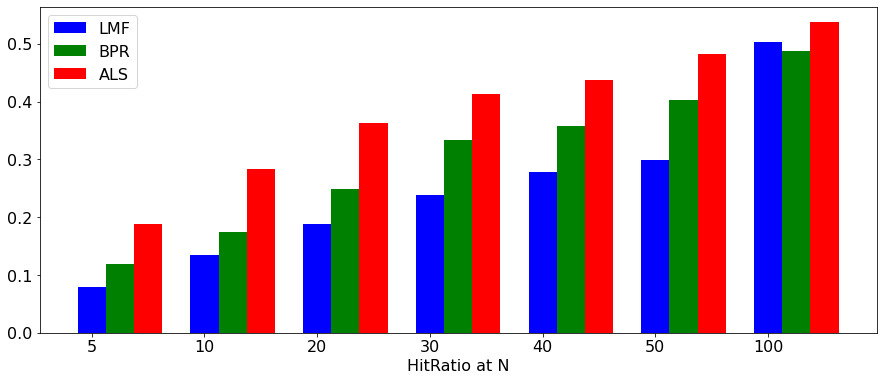

In [61]:
import matplotlib.pyplot as plt
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.rcParams['font.size'] = '16'

plt.bar(X + 0.00, plot_hit_ratio_lmf, color = 'b', width = 0.25, label='LMF')
plt.bar(X + 0.25, plot_hit_ratio_bpr, color = 'g', width = 0.25, label='BPR')
plt.bar(X + 0.50, plot_hit_ratio_als, color = 'r', width = 0.25, label='ALS')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

# Popularity based model

In [996]:
#creating popularity based model by sorting dataset by frequency values in descending order
popular_cust = data1.sort_values(by='count',ascending=False)

def pop_model(top_n):
    res = popular_cust['customer_code'][:top_n]
    temp= [1]*top_n
    return dict(zip(res,temp))

In [1000]:
# function will evaluate the performence of populartiy based model 
def evaluate_pop_model():

    recall_list=[5,10,20,30,40,50,100]
    top_n=1000
    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]


    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_code']==product]['customer_code'])
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]

    i=0
    for product in tqdm(set(test_set['product_code'])):


        res=pop_model(top_n)



        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1

    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].sum()/len(evaluation_recall_at_5),evaluation_recall_at_10[1].sum()/len(evaluation_recall_at_10),evaluation_recall_at_20[1].sum()/len(evaluation_recall_at_20),evaluation_recall_at_30[1].sum()/len(evaluation_recall_at_30),evaluation_recall_at_40[1].sum()/len(evaluation_recall_at_40),evaluation_recall_at_50[1].sum()/len(evaluation_recall_at_50),evaluation_recall_at_100[1].sum()/len(evaluation_recall_at_100)]

In [1001]:
plot_hit_ratio_pop = evaluate_pop_model()

  6%|▌         | 200/3589 [00:00<00:07, 442.41it/s]


In [ ]:
#performence comparision with popularity based model

Text(0.5, 0, 'HitRatio at N')

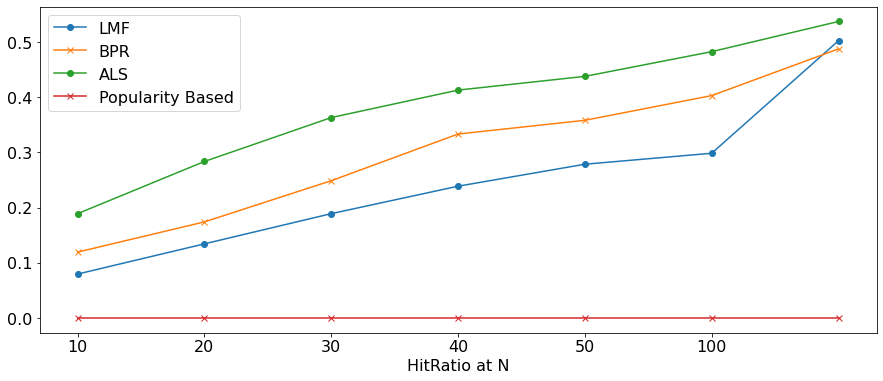

In [1014]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(plot_hit_ratio_lmf,label="LMF",marker='o')  #linestyle='--'
plt.plot(plot_hit_ratio_bpr,label="BPR",marker='x')
plt.plot(plot_hit_ratio_als,label="ALS",marker='o')
plt.plot(plot_hit_ratio_pop,label="Popularity Based",marker='x')
plt.legend()
plt.xticks([0,1,2,3,4,5],[10,20,30,40,50,100])
plt.xlabel("HitRatio at N")

# Two-Tower

In [ ]:
# Function will damle negative instances randomly and will return that set

In [78]:
from tqdm import tqdm

def get_neg_df(data1):
    
    neg_df=data1[data1['customer_code']==-1000][['customer_code','product_code']]
    
    print(len(neg_df))

    products = set(data1['product_code'])

    total_customer_set = set(data1['customer_code'])
    
    ratio=5

    i=0

    for p in tqdm(products):


        right_customer_set = set(data1[data1['product_code']==p]['customer_code'])
        wrtong_set = list(total_customer_set - right_customer_set)
       
        p_length=len(right_customer_set)

        wrong_cust = pd.Series(wrtong_set)[random.sample(range(0, len(wrtong_set)), p_length*ratio)]
            
        temp_df=pd.DataFrame([],columns=['customer_code','product_code'])
        
        temp_df['customer_code']=wrong_cust.values
        
        temp_df['product_code'] = p

        if(i==1):
            print(temp_df)
            
        neg_df = neg_df.append(temp_df)
        
        
    return neg_df


In [79]:
neg_df = get_neg_df(data1)

0


100%|██████████| 6600/6600 [10:18<00:00, 10.67it/s]


In [80]:
neg_df.head()

,customer_code,product_code
0,89281832,28171
1,498655532,28171
2,251221538,28171
3,36321795,28171
4,218223602,28171


In [418]:
neg_df = add_ids(neg_df)

In [419]:
neg_df.head()

,customer_code,product_code,customer_id,product_id,feedback
0,89281832,28171,68255,3516,0
1,498655532,28171,217761,3516,0
2,251221538,28171,189621,3516,0
3,36321795,28171,33521,3516,0
4,218223602,28171,170615,3516,0


In [456]:
#function will mix negative and postive instances together and suffle the whole set
def create_final_dataset(data1,neg_df):
    neg_df['feedback']=0
    data1['feedback']=1
    final_data=data1.copy()
    final_data=final_data.append(neg_df)
    final_data = final_data.sample(frac=1).reset_index(drop=True)
    return final_data

final_data = create_final_dataset(data1,neg_df)

In [457]:
final_data.head()

,customer_code,product_code,count,customer_id,product_id,feedback
0,224221950,37323,NaN,174142,4677,0
1,18108478,15014,NaN,16299,2195,0
2,57000498,18641,NaN,38553,2389,0
3,174122062,22055,NaN,140617,2879,0
4,260223021,40191,NaN,194672,5066,0


In [458]:
#negative instance will have frequency = 0
final_data['count'][final_data['count'].isnull()]=0

<ipython-input-458-97e813e01fc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['count'][final_data['count'].isnull()]=0


In [459]:
final_data.head()

,customer_code,product_code,count,customer_id,product_id,feedback
0,224221950,37323,0.0,174142,4677,0
1,18108478,15014,0.0,16299,2195,0
2,57000498,18641,0.0,38553,2389,0
3,174122062,22055,0.0,140617,2879,0
4,260223021,40191,0.0,194672,5066,0


In [ ]:
#for two-tower, trainset will be mixture of positive and negative instance

In [87]:
X_train = final_data[['customer_id','product_id']]
y_train = final_data['feedback']

# Two Tower Modeling using Cross Entropy Loss

In [135]:
total_customer=len(set(df6['customer_code']))
total_product=len(set(data1['product_code']))

In [112]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding,Dense,Dropout,Concatenate,Input,Embedding,merge,Multiply
from keras.callbacks import TensorBoard,EarlyStopping
import keras
from tensorflow.keras.utils import plot_model
import pydot

# GMF Two Tower Model

Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gmf_input1 (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
gmf_input2 (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_229 (Embedding)       (None, 1, 32)        7282880     gmf_input1[0][0]                 
__________________________________________________________________________________________________
embedding_230 (Embedding)       (None, 1, 32)        211200      gmf_input2[0][0]                 
___________________________________________________________________________________________

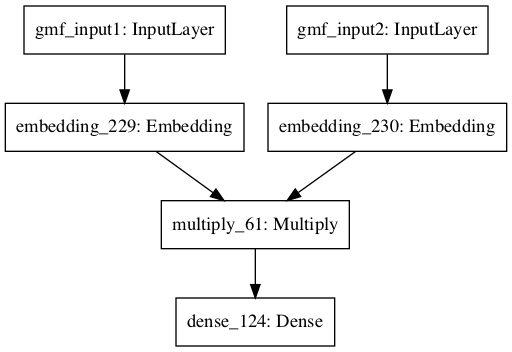

In [755]:
embedding_length=32

gmf_input1 = tf.keras.layers.Input((1 ), name="gmf_input1")
gmf_input2 = tf.keras.layers.Input((1 ), name="gmf_input2")

gmf_embedding1 = tf.keras.layers.Embedding(total_customer,embedding_length)(gmf_input1)
gmf_embedding2 = tf.keras.layers.Embedding(total_product,embedding_length)(gmf_input2)

gmf_merged = Multiply()([gmf_embedding1, gmf_embedding2])

gmf_hidden = Dense(1, activation="sigmoid")(gmf_merged)
gmf = Model(inputs=[gmf_input1, gmf_input2], outputs=gmf_hidden)
gmf.summary()

plot_model(gmf)

In [714]:
# np.array(X_train['customer_id']).reshape(-1,1)

In [756]:
gmf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','mae'])
early_stopping_cb = EarlyStopping(patience=1,restore_best_weights=True,monitor='loss')

gmf.fit(
[
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id'])
],
y_train,epochs=1,batch_size=1000,verbose=1,callbacks=[early_stopping_cb])

4782/4782 [==============================] - 91s 19ms/step - loss: 0.5223 - accuracy: 0.8365 - mae: 0.3713


In [209]:
# y_train.value_counts()

In [757]:
plot_hit_ratio_gmf = evaluate_tower(gmf)

  0%|          | 6/3589 [00:00<02:15, 26.39it/s]

customer_code             235
product_code            18641
count                       1
customer_id                 0
product_id               2389
customer_type          Retail
product_type            Wines
single_bottle_price     14.99
customer_type_id            1
product_type_id             6
confidence                 11
Name: 2, dtype: object
(array([], dtype=int64),)
{330: 0.70433074, 225: 0.58442235, 616: 0.54968, 1091: 0.5394507, 119: 0.5160844, 795: 0.49284557, 400: 0.45618856, 1059: 0.4485075, 996: 0.4240057, 1151: 0.42051658, 1106: 0.4165186, 149: 0.38843134, 114: 0.3735582, 768: 0.3524403, 950: 0.3510835, 641: 0.34652954, 817: 0.34436327, 640: 0.32532766, 1122: 0.32173675, 624: 0.32053518, 443: 0.3169958, 151: 0.31196594, 750: 0.30925727, 667: 0.30891368, 670: 0.29286125, 614: 0.29198676, 195: 0.29010534, 239: 0.2897509, 237: 0.28609982, 1078: 0.28404534, 972: 0.28340387, 369: 0.2780767, 986: 0.27258185, 875: 0.27087402, 354: 0.27024025, 1070: 0.26560536, 941: 0.26288167

  6%|▌         | 200/3589 [00:06<01:53, 29.98it/s]


In [758]:
plot_hit_ratio_gmf

[0.18407960199004975,
 0.22388059701492538,
 0.25870646766169153,
 0.2935323383084577,
 0.35323383084577115,
 0.4129353233830846,
 0.5472636815920398]

In [727]:
test_set.head()

,customer_code,product_code,count,customer_id,product_id,customer_type,product_type,single_bottle_price,customer_type_id,product_type_id,confidence
0,235,09018,1,0,1326,Retail,Wines,12.99,1,6,11
1,235,13073,1,0,1637,Retail,Wines,11.99,1,6,11
2,235,18641,1,0,2389,Retail,Wines,14.99,1,6,11
3,235,39319,1,0,4889,Retail,Wines,7.99,1,6,11
4,235,39362,1,0,4914,Retail,Wines,8.99,1,6,11


# NCF Two Tower Model

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ncf_input1 (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
ncf_input2 (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_227 (Embedding)       (None, 1, 32)        7282880     ncf_input1[0][0]                 
__________________________________________________________________________________________________
embedding_228 (Embedding)       (None, 1, 32)        211200      ncf_input2[0][0]                 
___________________________________________________________________________________________

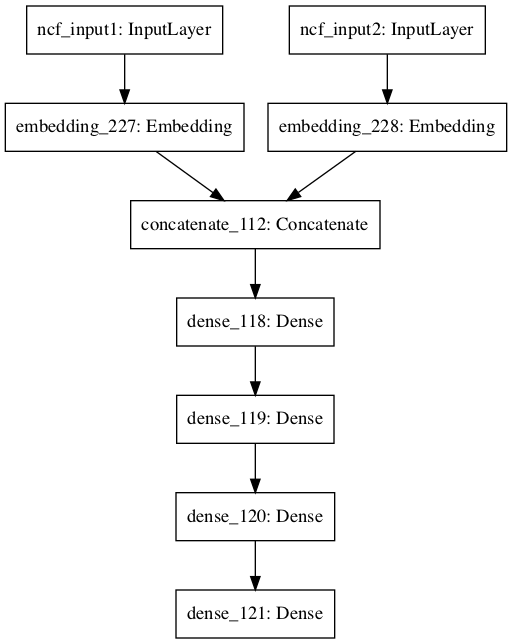

In [743]:
import tensorflow as tf

ncf_input1 = tf.keras.layers.Input((1 ), name="ncf_input1")
ncf_input2 = tf.keras.layers.Input((1 ), name="ncf_input2")

ncf_embedding1 = tf.keras.layers.Embedding(total_customer, embedding_length)(ncf_input1)
ncf_embedding2 = tf.keras.layers.Embedding(total_product, embedding_length)(ncf_input2)

ncf_concat = tf.keras.layers.Concatenate()([ncf_embedding1, ncf_embedding2])
ncf_hidden1 = Dense(8, activation="relu",kernel_initializer = 'he_normal')(ncf_concat)
ncf_hidden2 = Dense(4, activation="relu",kernel_initializer = 'he_normal')(ncf_hidden1)
ncf_hidden3 = Dense(2, activation="relu",kernel_initializer = 'he_normal')(ncf_hidden2)
ncf_hidden4 = Dense(1, activation="sigmoid")(ncf_hidden3)
ncf = Model(inputs=[ncf_input1, ncf_input2], outputs=ncf_hidden4)
ncf.summary()
plot_model(ncf)

In [744]:
ncf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','mae'])
early_stopping_cb = EarlyStopping(patience=1,restore_best_weights=True,monitor='loss')

ncf.fit(
[
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id'])
],
y_train,epochs=1,batch_size=1000,verbose=1,callbacks=[early_stopping_cb])

Epoch 1/2
4782/4782 [==============================] - 92s 19ms/step - loss: 0.4359 - accuracy: 0.8415 - mae: 0.2751
Epoch 2/2
4782/4782 [==============================] - 91s 19ms/step - loss: 0.3694 - accuracy: 0.8587 - mae: 0.2222


In [745]:
plot_hit_ratio_ncf = evaluate_tower(ncf)

  0%|          | 8/3589 [00:00<03:03, 19.51it/s]

customer_code             235
product_code            18641
count                       1
customer_id                 0
product_id               2389
customer_type          Retail
product_type            Wines
single_bottle_price     14.99
customer_type_id            1
product_type_id             6
confidence                 11
Name: 2, dtype: object
(array([], dtype=int64),)
{330: 0.865547, 1059: 0.71985185, 119: 0.69497776, 795: 0.47532424, 225: 0.47032174, 1151: 0.4371473, 641: 0.40249455, 206: 0.38048667, 996: 0.35151103, 1091: 0.33037993, 400: 0.2991089, 616: 0.298176, 149: 0.2926923, 114: 0.28721377, 1122: 0.28500944, 1088: 0.28453702, 237: 0.28005728, 768: 0.27698708, 443: 0.27198058, 667: 0.26921368, 831: 0.25693414, 1106: 0.25035882, 1078: 0.24664861, 817: 0.23285533, 1131: 0.2324848, 950: 0.23132531, 151: 0.23021156, 1004: 0.22903399, 362: 0.22598076, 738: 0.22069347, 381: 0.21476935, 338: 0.21163964, 168: 0.20735419, 614: 0.19805159, 798: 0.1949195, 354: 0.19240333, 176: 0.1

  6%|▌         | 200/3589 [00:06<01:54, 29.53it/s]


In [746]:
plot_hit_ratio_ncf

[0.1791044776119403,
 0.21393034825870647,
 0.2835820895522388,
 0.31840796019900497,
 0.3582089552238806,
 0.4079601990049751,
 0.5920398009950248]

# NueMF Two Tower Model

In [759]:
full_concat = tf.keras.layers.Concatenate()([ncf_hidden4, gmf_hidden])
full_hidden = Dense(1, activation="sigmoid")(full_concat)
full_model = Model(inputs=[ncf_input1, ncf_input2,gmf_input1, gmf_input2], outputs=full_hidden)

for layer in full_model.layers[0:-1]:
    layer.trainable=False

In [760]:
from keras.optimizers import Adam,SGD
opt=SGD(learning_rate=0.001,momentum=0.5)
full_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','mae'])
early_stopping_cb = EarlyStopping(patience=3,restore_best_weights=True,monitor='loss')
full_model.fit(
    [
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id'])
        
    ],y_train,epochs=3,batch_size=1000, verbose=1,callbacks=[early_stopping_cb])

Epoch 1/3
4782/4782 [==============================] - 5s 999us/step - loss: 0.5185 - accuracy: 0.8372 - mae: 0.3760
Epoch 2/3
4782/4782 [==============================] - 5s 972us/step - loss: 0.3527 - accuracy: 0.8637 - mae: 0.2179
Epoch 3/3
4782/4782 [==============================] - 5s 980us/step - loss: 0.3499 - accuracy: 0.8643 - mae: 0.2076


In [761]:
plot_hit_ratio_full_model = evaluate_full_tower(full_model)

  0%|          | 5/3589 [00:00<02:57, 20.18it/s]

{119: 0.802107, 225: 0.7819094, 616: 0.75250816, 1091: 0.72606444, 1059: 0.7088934, 795: 0.64250076, 149: 0.5626232, 114: 0.53643405, 950: 0.5058446, 817: 0.5043055, 641: 0.49891683, 1106: 0.49116978, 151: 0.46861953, 768: 0.4521364, 1122: 0.44051003, 237: 0.42980617, 667: 0.4031314, 670: 0.40039176, 750: 0.37704477, 170: 0.37393385, 443: 0.3562758, 1078: 0.35566404, 195: 0.3439656, 338: 0.3314498, 640: 0.3162072, 738: 0.30375803, 280: 0.3030337, 624: 0.29810047, 831: 0.29068077, 1088: 0.28424814, 402: 0.28424618, 972: 0.28391027, 941: 0.28293243, 354: 0.27774307, 1080: 0.27050436, 614: 0.27032244, 875: 0.2606702, 369: 0.25941128, 362: 0.2506879, 381: 0.25067604, 1042: 0.24748679, 832: 0.24404036, 206: 0.23906016, 168: 0.23783144, 1040: 0.23709701, 1098: 0.2323352, 741: 0.22054502, 230: 0.21616268, 973: 0.21517734, 299: 0.21236339, 1067: 0.21006475, 986: 0.20875272, 602: 0.2085927, 811: 0.207332, 139: 0.20274743, 465: 0.20149286, 370: 0.19859883, 984: 0.19752759, 102: 0.1964148, 1115: 

  6%|▌         | 200/3589 [00:07<02:12, 25.56it/s]


In [762]:
plot_hit_ratio_full_model

[0.19402985074626866,
 0.22885572139303484,
 0.2537313432835821,
 0.31343283582089554,
 0.373134328358209,
 0.4129353233830846,
 0.582089552238806]

In [ ]:
#performence comparision among all thre deifferent architectures of two-tower

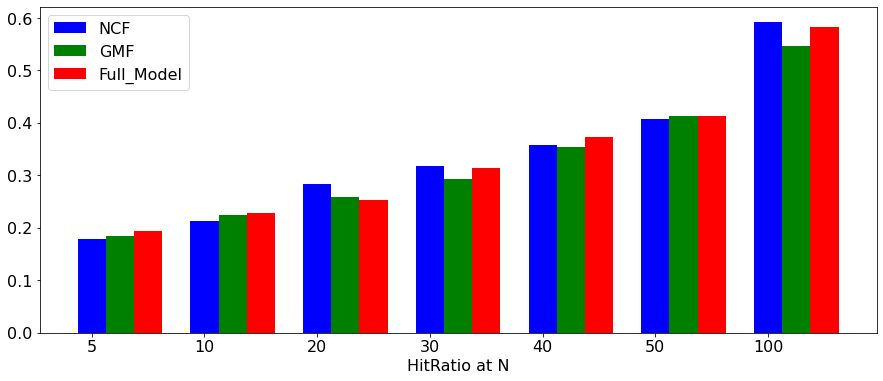

In [763]:
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.bar(X + 0.00, plot_hit_ratio_ncf, color = 'b', width = 0.25, label='NCF')
plt.bar(X + 0.25, plot_hit_ratio_gmf, color = 'g', width = 0.25, label='GMF')
plt.bar(X + 0.50, plot_hit_ratio_full_model, color = 'r', width = 0.25, label='NueMF_Model')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

In [ ]:
#performence comparision among all three 
#deifferent architectures of two-tower and ALS, BPR and LMF

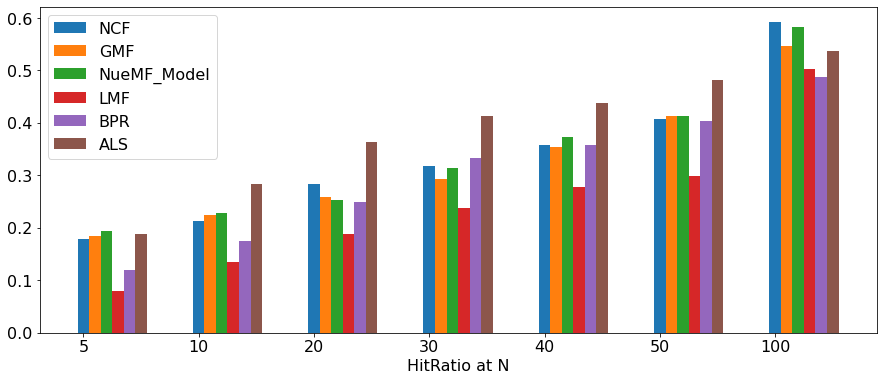

In [993]:
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.bar(X + 0.00, plot_hit_ratio_ncf, width = 0.10, label='NCF')
plt.bar(X + 0.10, plot_hit_ratio_gmf, width = 0.10, label='GMF')
plt.bar(X + 0.20, plot_hit_ratio_full_model, width = 0.10, label='NueMF_Model')

plt.bar(X + 0.30, plot_hit_ratio_lmf, width = 0.10, label='LMF')
plt.bar(X + 0.40, plot_hit_ratio_bpr, width = 0.10, label='BPR')
plt.bar(X + 0.50, plot_hit_ratio_als, width = 0.10, label='ALS')

plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

Text(0.5, 0, 'Recall at N')

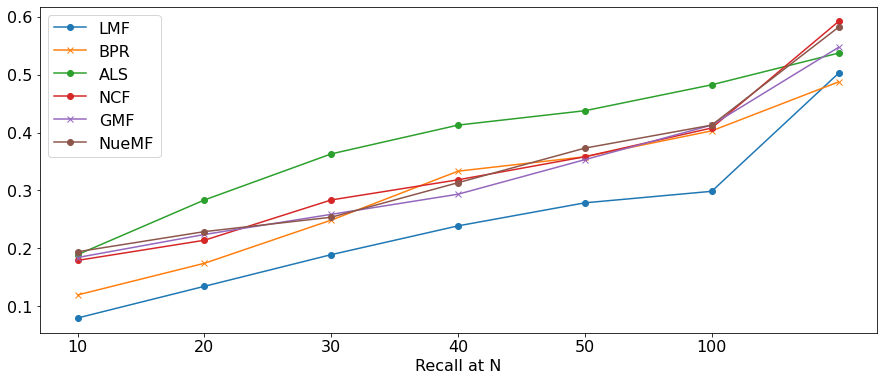

In [991]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(plot_hit_ratio_lmf,label="LMF",marker='o')  #linestyle='--'
plt.plot(plot_hit_ratio_bpr,label="BPR",marker='x')
plt.plot(plot_hit_ratio_als,label="ALS",marker='o')

plt.plot(plot_hit_ratio_ncf,label="NCF",marker='o')  #linestyle='--'
plt.plot(plot_hit_ratio_gmf,label="GMF",marker='x')
plt.plot(plot_hit_ratio_full_model,label="NueMF",marker='o')

plt.legend()
plt.xticks([0,1,2,3,4,5],[10,20,30,40,50,100])
plt.xlabel("Recall at N")

# Two Tower Modelling Using Customized Loss

In [847]:
alpha=2
als_af=final_data.copy()
als_af['confidence']=1+alpha*als_af['count']
als_af

,customer_code,product_code,count,customer_id,product_id,feedback,customer_type,product_type,single_bottle_price,customer_type_id,product_type_id,confidence
0,224221950,37323,0.0,174142,4677,0,Retail,Wines,9.49,1,6,1.0
1,18108478,15014,0.0,16299,2195,0,Retail,Wines,9.99,1,6,1.0
2,57000498,18641,0.0,38553,2389,0,Retail,Wines,14.99,1,6,1.0
3,174122062,22055,0.0,140617,2879,0,Retail,Wines,44.99,1,6,1.0
4,260223021,40191,0.0,194672,5066,0,Retail,Wines,11.99,1,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4781971,298251262,40174,1.0,202853,5053,1,Retail,Wines,9.99,1,6,3.0
4781972,86205363,04674,0.0,65104,875,0,Retail,Wines,16.99,1,6,1.0
4781973,73204241,37234,0.0,52727,4634,0,Retail,Wines,13.99,1,6,1.0
4781974,23297797,22417,2.0,23724,2982,1,Commercial,Wines,69.99,0,6,5.0


In [848]:
X_train = als_af[['customer_id','product_id']]
y_train = als_af[['feedback','confidence']]

# GMF with Customized loss

In [849]:
from keras import backend as K
def custom_loss():
    def loss_f(y_true,y_pred):
        confidence = tf.reshape(y_true[:,1], [-1, 1])
        feedback = tf.reshape(y_true[:,0], [-1, 1])
        diff = (y_pred-feedback)*confidence
        temp = K.square(diff)
        return temp
    return loss_f

In [850]:
embedding_length=32
als_gmf_input1 = tf.keras.layers.Input((1 ), name="als_gmf_input1")
als_gmf_input2 = tf.keras.layers.Input((1 ), name="als_gmf_input2")
als_gmf_embedding1 = tf.keras.layers.Embedding(total_customer,embedding_length)(als_gmf_input1)
als_gmf_embedding2 = tf.keras.layers.Embedding(total_product,embedding_length)(als_gmf_input2)
als_gmf_merged = Multiply()([als_gmf_embedding1, als_gmf_embedding2])
als_gmf_hidden = Dense(1, activation="sigmoid")(als_gmf_merged)
als_gmf = Model(inputs=[als_gmf_input1, als_gmf_input2], outputs=als_gmf_hidden)
als_gmf.summary()

Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
als_gmf_input1 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
als_gmf_input2 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_259 (Embedding)       (None, 1, 32)        7282880     als_gmf_input1[0][0]             
__________________________________________________________________________________________________
embedding_260 (Embedding)       (None, 1, 32)        211200      als_gmf_input2[0][0]             
___________________________________________________________________________________________

In [851]:
als_gmf.compile(loss=custom_loss(), optimizer='adam', metrics=['mae'])
early_stopping_cb = EarlyStopping(patience=2,restore_best_weights=True,monitor='loss')
als_gmf.fit(
    [
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id'])
    ],
    y_train.values,epochs=1,batch_size=1000, verbose=1,callbacks=[early_stopping_cb])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4782/4782 [==============================] - 91s 19ms/step - loss: 0.7080 - mae: 0.5765


In [852]:
plot_hit_ratio_als_gmf = evaluate_tower(als_gmf)

  0%|          | 8/3589 [00:00<02:25, 24.61it/s]

customer_code             235
product_code            18641
count                       1
customer_id                 0
product_id               2389
customer_type          Retail
product_type            Wines
single_bottle_price     14.99
customer_type_id            1
product_type_id             6
confidence                 11
Name: 2, dtype: object
(array([], dtype=int64),)
{330: 0.9407245, 119: 0.93361694, 225: 0.9230177, 1059: 0.9181551, 795: 0.916109, 149: 0.9148494, 400: 0.9049909, 1151: 0.9014011, 1106: 0.901035, 641: 0.8993952, 114: 0.8913712, 1091: 0.88600624, 616: 0.8832196, 768: 0.8826608, 950: 0.87570614, 239: 0.873556, 996: 0.8684085, 443: 0.86604315, 354: 0.8659827, 151: 0.8531981, 1004: 0.8454244, 817: 0.8430778, 1131: 0.8417549, 624: 0.83967614, 667: 0.83933747, 1078: 0.8375534, 465: 0.837298, 123: 0.82948416, 738: 0.8293806, 338: 0.8254013, 1122: 0.8227145, 280: 0.8153027, 195: 0.8116757, 750: 0.81145793, 1089: 0.81089485, 595: 0.8099093, 536: 0.7997622, 1088: 0.797266

  6%|▌         | 200/3589 [00:06<01:50, 30.71it/s]


In [853]:
plot_hit_ratio_als_gmf

[0.14427860696517414,
 0.19900497512437812,
 0.24875621890547264,
 0.26865671641791045,
 0.2736318407960199,
 0.32338308457711445,
 0.5572139303482587]

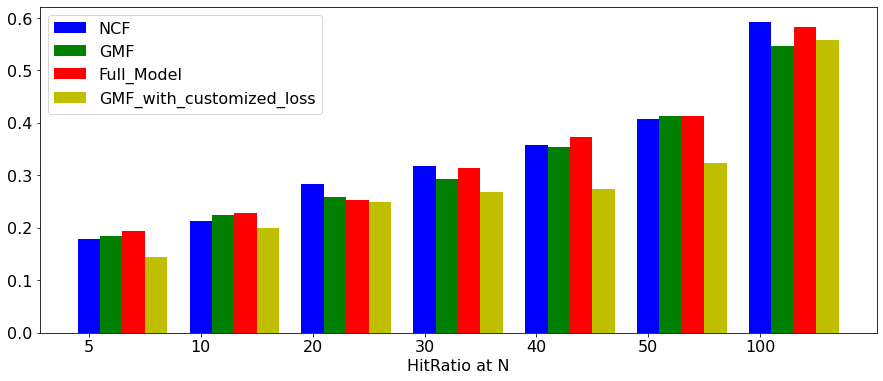

In [854]:
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.bar(X + 0.00, plot_hit_ratio_ncf, color = 'b', width = 0.20, label='NCF')
plt.bar(X + 0.20, plot_hit_ratio_gmf, color = 'g', width = 0.20, label='GMF')
plt.bar(X + 0.40, plot_hit_ratio_full_model, color = 'r', width = 0.20, label='Full_Model')
plt.bar(X + 0.60, plot_hit_ratio_als_gmf, color = 'y', width = 0.20, label='GMF_with_customized_loss')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

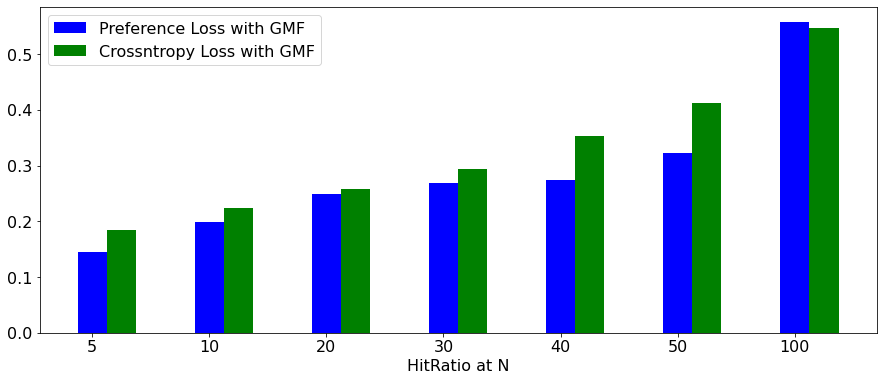

In [855]:
import matplotlib.pyplot as plt
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.rcParams['font.size'] = '16'

plt.bar(X + 0.00, plot_hit_ratio_als_gmf, color = 'b', width = 0.25, label='Customized Loss with GMF')
plt.bar(X + 0.25, plot_hit_ratio_gmf, color = 'g', width = 0.25, label='Crossntropy Loss with GMF')
# plt.bar(X + 0.50, plot_recall_full_model, color = 'r', width = 0.25, label='Full_Model')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

# NCF with Customized loss

In [856]:
als_ncf_input1 = tf.keras.layers.Input((1 ), name="als_ncf_input1")

als_ncf_input2 = tf.keras.layers.Input((1 ), name="als_ncf_input2")

embedding_length=100

als_ncf_embedding1 = tf.keras.layers.Embedding(total_customer, embedding_length)(als_ncf_input1)
als_ncf_embedding2 = tf.keras.layers.Embedding(total_product, embedding_length)(als_ncf_input2)
_
als_ncf_concat = tf.keras.layers.Concatenate()([als_ncf_embedding1, als_ncf_embedding2])
als_ncf_hidden1 = Dense(8, activation="relu",kernel_initializer = 'he_normal')(als_ncf_concat)
als_ncf_hidden2 = Dense(4, activation="relu",kernel_initializer = 'he_normal')(als_ncf_hidden1)
als_ncf_hidden3 = Dense(2, activation="relu",kernel_initializer = 'he_normal')(als_ncf_hidden2)
als_ncf_hidden4 = Dense(1, activation="sigmoid")(als_ncf_hidden3)
als_ncf = Model(inputs=[als_ncf_input1, als_ncf_input2], outputs=als_ncf_hidden4)
als_ncf.summary()



Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
als_ncf_input1 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
als_ncf_input2 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_261 (Embedding)       (None, 1, 100)       22759000    als_ncf_input1[0][0]             
__________________________________________________________________________________________________
embedding_262 (Embedding)       (None, 1, 100)       660000      als_ncf_input2[0][0]             
___________________________________________________________________________________________

In [857]:
als_ncf.compile(loss=custom_loss(), optimizer='adam', metrics=['mae'])
early_stopping_cb = EarlyStopping(patience=2,restore_best_weights=True,monitor='loss')
als_ncf.fit(
    [
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id'])
    ],y_train.values,epochs=1,batch_size=1000, verbose=1,callbacks=[early_stopping_cb])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4782/4782 [==============================] - 278s 58ms/step - loss: 0.5687 - mae: 0.5795


In [858]:
plot_hit_ratio_als_ncf = evaluate_tower(als_ncf)

  0%|          | 5/3589 [00:00<03:02, 19.62it/s]

customer_code             235
product_code            18641
count                       1
customer_id                 0
product_id               2389
customer_type          Retail
product_type            Wines
single_bottle_price     14.99
customer_type_id            1
product_type_id             6
confidence                 11
Name: 2, dtype: object
(array([], dtype=int64),)
{795: 0.99240327, 330: 0.9907891, 149: 0.982414, 119: 0.9714953, 641: 0.97102463, 667: 0.96640533, 1059: 0.96379894, 750: 0.96330464, 354: 0.95705664, 624: 0.9541055, 400: 0.94966805, 1091: 0.9432681, 1122: 0.9430577, 114: 0.93888867, 616: 0.93780494, 1106: 0.93138504, 768: 0.9195455, 996: 0.9138171, 443: 0.911819, 1040: 0.9109155, 1078: 0.89206696, 225: 0.89026886, 195: 0.87126875, 446: 0.8544704, 670: 0.85374916, 1131: 0.8485739, 24: 0.8482475, 362: 0.8470582, 338: 0.84704393, 536: 0.84694153, 239: 0.8430381, 244: 0.8426975, 280: 0.8410542, 817: 0.83457226, 206: 0.82616633, 950: 0.8140058, 811: 0.81262773, 831: 

  6%|▌         | 200/3589 [00:07<01:59, 28.41it/s]


In [859]:
plot_hit_ratio_als_ncf

[0.15422885572139303,
 0.19402985074626866,
 0.24875621890547264,
 0.29850746268656714,
 0.3283582089552239,
 0.3681592039800995,
 0.5920398009950248]

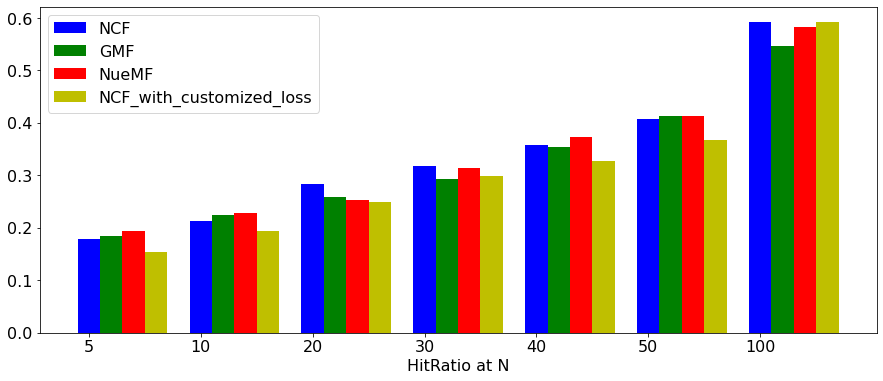

In [867]:
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.bar(X + 0.00, plot_hit_ratio_ncf, color = 'b', width = 0.20, label='NCF')
plt.bar(X + 0.20, plot_hit_ratio_gmf, color = 'g', width = 0.20, label='GMF')
plt.bar(X + 0.40, plot_hit_ratio_full_model, color = 'r', width = 0.20, label='NueMF')
plt.bar(X + 0.60, plot_hit_ratio_als_ncf, color = 'y', width = 0.20, label='NCF_with_customized_loss')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

# NueMF Two Tower Model with customized loss

In [860]:
als_full_concat = tf.keras.layers.Concatenate()([als_ncf_hidden4, als_gmf_hidden])
als_full_hidden = Dense(1, activation="sigmoid")(als_full_concat)
als_full_model = Model(inputs=[als_ncf_input1, als_ncf_input2,als_gmf_input1, als_gmf_input2], outputs=als_full_hidden)
als_full_model.summary()


for layer in als_full_model.layers[0:-1]:
    layer.trainable=False

als_full_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_loss')

als_full_model.compile(loss=custom_loss(), optimizer='adam', metrics=['mae'])
early_stopping_cb = EarlyStopping(patience=1,restore_best_weights=True,monitor='loss')
als_full_model.fit(
    [
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['product_id'])
    ],y_train.values,epochs=3,batch_size=1000, validation_split=.2, verbose=1,callbacks=[early_stopping_cb])

Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
als_ncf_input1 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
als_ncf_input2 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_261 (Embedding)       (None, 1, 100)       22759000    als_ncf_input1[0][0]             
__________________________________________________________________________________________________
embedding_262 (Embedding)       (None, 1, 100)       660000      als_ncf_input2[0][0]             
___________________________________________________________________________________________

In [861]:
plot_hit_ratio_als_full_model = evaluate_tower(als_ncf)

  0%|          | 6/3589 [00:00<02:57, 20.13it/s]

customer_code             235
product_code            18641
count                       1
customer_id                 0
product_id               2389
customer_type          Retail
product_type            Wines
single_bottle_price     14.99
customer_type_id            1
product_type_id             6
confidence                 11
Name: 2, dtype: object
(array([], dtype=int64),)
{795: 0.99240327, 330: 0.9907891, 149: 0.982414, 119: 0.9714953, 641: 0.97102463, 667: 0.96640533, 1059: 0.96379894, 750: 0.96330464, 354: 0.95705664, 624: 0.9541055, 400: 0.94966805, 1091: 0.9432681, 1122: 0.9430577, 114: 0.93888867, 616: 0.93780494, 1106: 0.93138504, 768: 0.9195455, 996: 0.9138171, 443: 0.911819, 1040: 0.9109155, 1078: 0.89206696, 225: 0.89026886, 195: 0.87126875, 446: 0.8544704, 670: 0.85374916, 1131: 0.8485739, 24: 0.8482475, 362: 0.8470582, 338: 0.84704393, 536: 0.84694153, 239: 0.8430381, 244: 0.8426975, 280: 0.8410542, 817: 0.83457226, 206: 0.82616633, 950: 0.8140058, 811: 0.81262773, 831: 

  6%|▌         | 200/3589 [00:06<01:53, 29.78it/s]


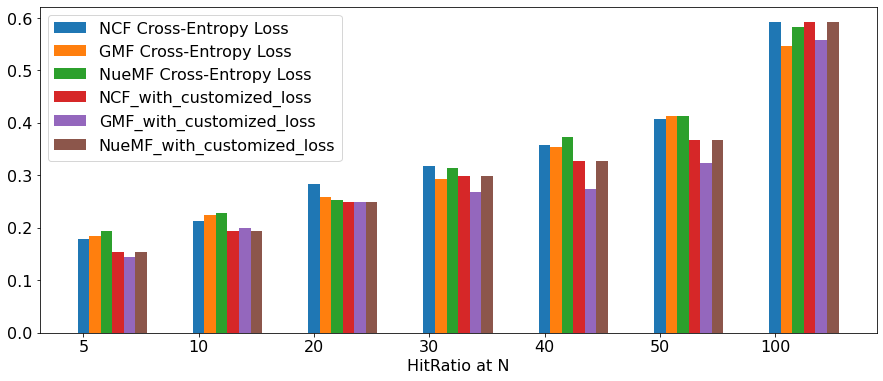

In [1008]:
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.bar(X + 0.00, plot_hit_ratio_ncf, width = 0.10, label='NCF Cross-Entropy Loss')
plt.bar(X + 0.10, plot_hit_ratio_gmf, width = 0.10, label='GMF Cross-Entropy Loss')
plt.bar(X + 0.20, plot_hit_ratio_full_model, width = 0.10, label='NueMF Cross-Entropy Loss')
plt.bar(X + 0.30, plot_hit_ratio_als_ncf, width = 0.10, label='NCF_with_customized_loss')

plt.bar(X + 0.40, plot_hit_ratio_als_gmf, width = 0.10, label='GMF_with_customized_loss')

plt.bar(X + 0.50, plot_hit_ratio_als_full_model, width = 0.10, label='NueMF_with_customized_loss')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

In [733]:
#function used to evaluated performence of GMF and NCF model.

#it cannot evaluate full_model(NueMF)

def evaluate_tower(model):
    total_customer_set = set(data1['customer_id'])

    top_n=1000
    recall_list=[5,10,20,30,40,50,100]

    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]


    def select_top_N(pred,n=50):
        rev=np.argsort(pred.flatten())[::-1]
        res=rev[:n]
        return res

    def predict(product,all_cust_one_hot,test_sub_set):
        
        #print(product)

        #one_hot_prod_code = [one_hot(str(product),total_product)]*len(test_sub_set)    
        
        one_hot_prod_code = [product]*len(test_sub_set)  
        
#         print("all_cust_one_hot = ",all_cust_one_hot)
#         print("one_hot_prod_code = ",one_hot_prod_code)
        
        predictions = model.predict([tf.convert_to_tensor(all_cust_one_hot),tf.convert_to_tensor(one_hot_prod_code)])
        res_index = select_top_N(predictions,top_n)
        return res_index,predictions


    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_id']==product]['customer_id'])
#         print("for prodcut_id = ",product)
#         print("db_cust = ",db_customers)
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
#         print("common_customers with in ",n,"are : ",common_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]


    i=0
    result=pd.DataFrame(columns=['Product','Recall','Retrieved Customers','Customers In DB'])
    result=list()
    for product in tqdm(set(test_set['product_id'])):

        right_customer_set = set(data1[data1['product_id']==product]['customer_id'])

        test_sub_set = list(test_set[test_set['product_id']==product]['customer_id'])[0]

        wrtong_set = list(total_customer_set - right_customer_set)  [:top_n-1]

        wrtong_set.append(test_sub_set)

        test_sub_set=wrtong_set

        #all_cust_one_hot = [one_hot(str(cust),total_customer) for cust in test_sub_set]
        
        all_cust_one_hot = test_sub_set

        res_index,predictions = predict(product,all_cust_one_hot,test_sub_set)
        res = dict(zip(np.array(test_sub_set)[res_index],predictions[res_index].flatten()))

        if(i==2):
            print(test_set.iloc[i])
            print(np.where(np.array(res.keys()==test_set.iloc[i]['customer_id'])))
            print(res)
            

        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1


    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].mean(),evaluation_recall_at_10[1].mean(),evaluation_recall_at_20[1].mean(),evaluation_recall_at_30[1].mean(),evaluation_recall_at_40[1].mean(),evaluation_recall_at_50[1].mean(),evaluation_recall_at_100[1].mean()]

In [264]:
#function is used to evaluate full_model(NueMF) only

def evaluate_full_tower(model):
    total_customer_set = set(data1['customer_id'])

    top_n=1000
    recall_list=[5,10,20,30,40,50,100]

    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]


    def select_top_N(pred,n=50):
        rev=np.argsort(pred.flatten())[::-1]
        res=rev[:n]
        return res

    def predict(product,all_cust_one_hot,test_sub_set):
        
        #print(product)

        #one_hot_prod_code = [one_hot(str(product),total_product)]*len(test_sub_set)    
        
        one_hot_prod_code = [product]*len(test_sub_set)  
        
#         print("all_cust_one_hot = ",all_cust_one_hot)
#         print("one_hot_prod_code = ",one_hot_prod_code)
        
        predictions = model.predict([tf.convert_to_tensor(all_cust_one_hot),tf.convert_to_tensor(one_hot_prod_code),tf.convert_to_tensor(all_cust_one_hot),tf.convert_to_tensor(one_hot_prod_code)])
        res_index = select_top_N(predictions,top_n)
        return res_index,predictions


    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_id']==product]['customer_id'])
#         print("for prodcut_id = ",product)
#         print("db_cust = ",db_customers)
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
#         print("common_customers with in ",n,"are : ",common_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]


    i=0
    result=pd.DataFrame(columns=['Product','Recall','Retrieved Customers','Customers In DB'])
    result=list()
    for product in tqdm(set(test_set['product_id'])):

        right_customer_set = set(data1[data1['product_id']==product]['customer_id'])

        test_sub_set = list(test_set[test_set['product_id']==product]['customer_id'])[0]

        wrtong_set = list(total_customer_set - right_customer_set)  [:top_n-1]

        wrtong_set.append(test_sub_set)

        test_sub_set=wrtong_set

        #all_cust_one_hot = [one_hot(str(cust),total_customer) for cust in test_sub_set]
        
        all_cust_one_hot = test_sub_set

        res_index,predictions = predict(product,all_cust_one_hot,test_sub_set)
        res = dict(zip(np.array(test_sub_set)[res_index],predictions[res_index].flatten()))

        if(i==1):
            print(res)

        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1


    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].mean(),evaluation_recall_at_10[1].mean(),evaluation_recall_at_20[1].mean(),evaluation_recall_at_30[1].mean(),evaluation_recall_at_40[1].mean(),evaluation_recall_at_50[1].mean(),evaluation_recall_at_100[1].mean()]

# Try feeding side information in Two Tower

In [888]:
def add_features(data,df_cust,df_prod):
    data = pd.merge(data[['customer_code','product_code','count','customer_id','product_id','feedback']], df_cust[['customer_code','customer_type']], on='customer_code', how='left')
    data = pd.merge(data, df_prod[['product_code','product_type','single_bottle_price']], on='product_code', how='left')
    data['customer_type'][data['customer_type'].isnull()] = 'no_customer_type'
    data['product_type'][data['product_type'].isnull()] = 'no_product_type'
#     data['single_bottle_price'][data['single_bottle_price'].isnull()] = 10
    return data

In [889]:
def add_features_test(data,df_cust,df_prod):
    data = pd.merge(data[['customer_code','product_code','count','customer_id','product_id']], df_cust[['customer_code','customer_type']], on='customer_code', how='left')
    data = pd.merge(data, df_prod[['product_code','product_type','single_bottle_price']], on='product_code', how='left')
    data['customer_type'][data['customer_type'].isnull()] = 'no_customer_type'
    data['product_type'][data['product_type'].isnull()] = 'no_product_type'
#     data['single_bottle_price'][data['single_bottle_price'].isnull()] = 10
    return data

In [890]:
final_data = add_features(final_data,df_cust,df_prod)

<ipython-input-888-8095c723c510>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['customer_type'][data['customer_type'].isnull()] = 'no_customer_type'
<ipython-input-888-8095c723c510>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['product_type'][data['product_type'].isnull()] = 'no_product_type'


In [891]:
test_set = add_features_test(test_set,df_cust,df_prod)

<ipython-input-889-1cc9c2fe55e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['customer_type'][data['customer_type'].isnull()] = 'no_customer_type'
<ipython-input-889-1cc9c2fe55e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['product_type'][data['product_type'].isnull()] = 'no_product_type'


In [892]:
final_data['customer_type_id'] = final_data['customer_type'].astype('category').cat.codes
final_data['product_type_id'] = final_data['product_type'].astype('category').cat.codes

In [893]:
cus_type_map  = final_data[['customer_type_id','customer_type']].drop_duplicates()
cus_type_map_dict = dict(zip(cus_type_map['customer_type'],cus_type_map['customer_type_id']))

prod_type_map = final_data[['product_type_id','product_type']].drop_duplicates()
prod_type_map_dict = dict(zip(prod_type_map['product_type'],prod_type_map['product_type_id']))

In [894]:
def data_id_map(data):
    data['customer_type_id'] = list(map(lambda x: cus_type_map_dict[x],data['customer_type']))
    data['product_type_id'] = list(map(lambda x: prod_type_map_dict[x],data['product_type']))
    return data

In [895]:
#final_data = data_id_map(final_data)
test_set = data_id_map(test_set)

In [876]:
final_data.head()

,customer_code,product_code,count,customer_id,product_id,feedback,customer_type,product_type,single_bottle_price,customer_type_id,product_type_id
0,224221950,37323,0.0,174142,4677,0,Retail,Wines,9.49,1,6
1,18108478,15014,0.0,16299,2195,0,Retail,Wines,9.99,1,6
2,57000498,18641,0.0,38553,2389,0,Retail,Wines,14.99,1,6
3,174122062,22055,0.0,140617,2879,0,Retail,Wines,44.99,1,6
4,260223021,40191,0.0,194672,5066,0,Retail,Wines,11.99,1,6


In [896]:
X_train = final_data
y_train = final_data['feedback']

In [881]:
#create a dataframe in which full data is stored train and test both

count_df=add_ids(count_df)
count_df=add_features_test(count_df,df_cust,df_prod)
count_df=data_id_map(count_df)
count_df

<ipython-input-869-1cc9c2fe55e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['customer_type'][data['customer_type'].isnull()] = 'no_customer_type'
<ipython-input-869-1cc9c2fe55e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['product_type'][data['product_type'].isnull()] = 'no_product_type'


,customer_code,product_code,count,customer_id,product_id,customer_type,product_type,single_bottle_price,customer_type_id,product_type_id
0,235,09018,1,0,1326,Retail,Wines,12.99,1,6
1,235,13073,1,0,1637,Retail,Wines,11.99,1,6
2,235,18641,1,0,2389,Retail,Wines,14.99,1,6
3,235,39319,1,0,4889,Retail,Wines,7.99,1,6
4,235,39362,1,0,4914,Retail,Wines,8.99,1,6
...,...,...,...,...,...,...,...,...,...,...
800580,960067390,14747,1,227586,2156,Retail,Wines,8.99,1,6
800581,960067391,49347,1,227587,5329,Retail,Spirits,26.00,1,5
800582,960067394,04167,1,227588,788,Retail,Wines,13.99,1,6
800583,960067394,06533,1,227588,1096,Retail,Wines,11.99,1,6


# GMF with side info

In [884]:
total_customer_type = len(set(final_data['customer_type']))
total_product_type = len(set(final_data['product_type']))

In [885]:
user_input_cust_code_side = tf.keras.layers.Input((1 ), name="user_input1")
user_input_cust_type_side= tf.keras.layers.Input((1 ), name="user_input2")
# input_freq = tf.keras.layers.Input((1 ), name="input_freq")


item_input_prod_code_side = tf.keras.layers.Input((1 ), name="item_input1")
item_input_prod_type_side = tf.keras.layers.Input((1 ), name="item_input2")
#item_input_side = tf.keras.layers.Input((4 ), name="item_input3")

Model: "model_98"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input1 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input2 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input1 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input2 (InputLayer)        [(None, 1)]          0                                            
___________________________________________________________________________________________

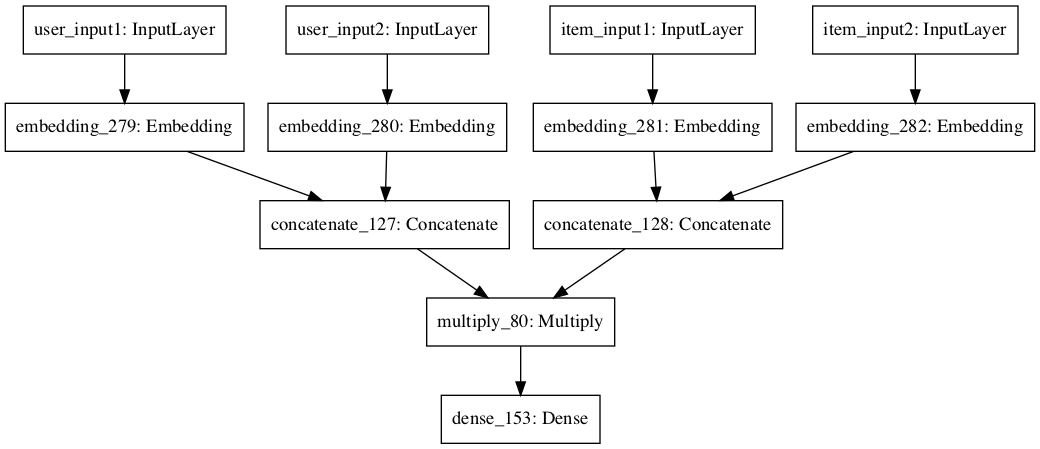

In [912]:
from keras.layers import Embedding,Dense,Dropout,Concatenate,Input,Embedding,merge,Multiply,Flatten,Dot

embedding_length=32

gmf_embedding_side1 = tf.keras.layers.Embedding(total_customer, embedding_length)(user_input_cust_code_side)

gmf_embedding_side12 = tf.keras.layers.Embedding(total_customer_type, 2)(user_input_cust_type_side)

gmf_embedding_side13 = tf.keras.layers.Embedding(total_product, embedding_length)(item_input_prod_code_side)

gmf_embedding_side14 = tf.keras.layers.Embedding(total_product_type, 2)(item_input_prod_type_side)

gmf_concat_side1 = tf.keras.layers.Concatenate()([gmf_embedding_side1,gmf_embedding_side12])#,user_input_side])
gmf_concat_side2 = tf.keras.layers.Concatenate()([ gmf_embedding_side13,gmf_embedding_side14])#,item_input_side])

gmf_merged_side = Multiply()([gmf_concat_side1, gmf_concat_side2])

gmf_hidden_side = Dense(1, activation="sigmoid")(gmf_merged_side)

gmf_side = Model(inputs=[user_input_cust_code_side,user_input_cust_type_side,
                         item_input_prod_code_side, item_input_prod_type_side], 
                 outputs=gmf_hidden_side)

gmf_side.summary()
plot_model(gmf_side)

In [913]:
gmf_side.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True,monitor='loss')

gmf_side.fit(
[
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['customer_type_id']),
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['product_type_id']),

],
y_train,epochs=1,batch_size=1000,verbose=1,callbacks=[early_stopping_cb])

4782/4782 [==============================] - 91s 19ms/step - loss: 0.4878 - accuracy: 0.8357


In [942]:
plot_hit_ratio_gmf_model_side = evaluate_tower_side_info(gmf_side)

  0%|          | 5/3589 [00:00<03:20, 17.91it/s]

{119: 0.48300573, 616: 0.45227084, 795: 0.4492037, 114: 0.4445251, 1106: 0.44449636, 149: 0.44274548, 1091: 0.4161291, 225: 0.40949932, 1122: 0.40707308, 722: 0.4002333, 206: 0.3922092, 1059: 0.38403764, 624: 0.38229412, 195: 0.37809834, 667: 0.3738796, 343: 0.37117562, 950: 0.35430813, 817: 0.3432016, 1131: 0.34008768, 443: 0.3359911, 641: 0.33399704, 1088: 0.3251572, 1078: 0.29139498, 151: 0.2833267, 402: 0.28281513, 102: 0.28091955, 362: 0.27722293, 831: 0.27464265, 237: 0.2723476, 687: 0.26848307, 170: 0.2676612, 465: 0.26472485, 1069: 0.26276803, 188: 0.2605508, 750: 0.26023397, 785: 0.25962713, 745: 0.25677565, 941: 0.25654313, 875: 0.25269207, 381: 0.2508334, 176: 0.24907021, 1035: 0.24814092, 230: 0.24752885, 341: 0.24660389, 446: 0.24265055, 1048: 0.24211822, 139: 0.24130696, 354: 0.23795703, 392: 0.2341794, 977: 0.23402335, 738: 0.23377478, 168: 0.23335904, 1004: 0.23206213, 277: 0.231697, 426: 0.23011996, 1112: 0.22842166, 1047: 0.22552116, 1042: 0.22495845, 811: 0.22381817,

  6%|▌         | 200/3589 [00:09<02:32, 22.21it/s]


In [944]:
plot_hit_ratio_gmf_model_side

[0.15920398009950248,
 0.1890547263681592,
 0.21890547263681592,
 0.26865671641791045,
 0.2935323383084577,
 0.32338308457711445,
 0.5621890547263682]

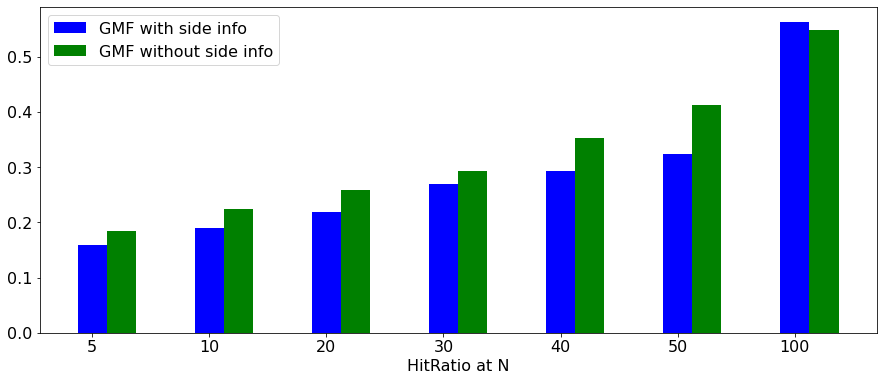

In [945]:
#performce comparison between GMF with and without side info
import matplotlib.pyplot as plt
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.rcParams['font.size'] = '16'

plt.bar(X + 0.00, plot_hit_ratio_gmf_model_side, color = 'b', width = 0.25, label='GMF with side info')
plt.bar(X + 0.25, plot_hit_ratio_gmf, color = 'g', width = 0.25, label='GMF without side info')
# plt.bar(X + 0.50, plot_recall_full_model, color = 'r', width = 0.25, label='Full_Model')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

# NCF with side info

In [916]:
ncf_user_input_cust_code_side = tf.keras.layers.Input((1 ), name="ncf_user_input1")
ncf_user_input_cust_type_side= tf.keras.layers.Input((1 ), name="ncf_user_input2")
# input_freq = tf.keras.layers.Input((1 ), name="input_freq")


ncf_item_input_prod_code_side = tf.keras.layers.Input((1 ), name="ncf_item_input1")
ncf_item_input_prod_type_side = tf.keras.layers.Input((1 ), name="ncf_item_input2")
#item_input_side = tf.keras.layers.Input((4 ), name="item_input3")

Model: "model_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ncf_user_input1 (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
ncf_user_input2 (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
ncf_item_input1 (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
ncf_item_input2 (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________

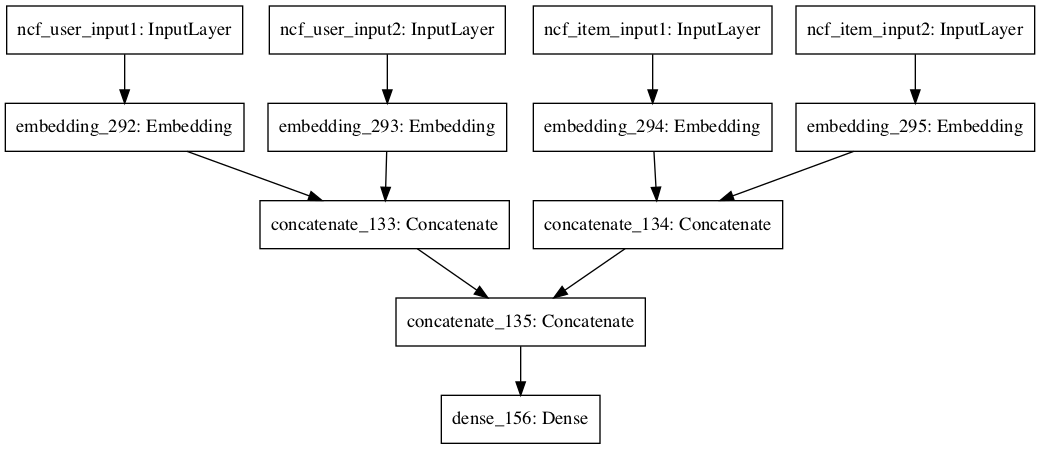

In [919]:
from keras.layers import Embedding,Dense,Dropout,Concatenate,Input,Embedding,merge,Multiply,Flatten,Dot

embedding_length=32

ncf_embedding_side1 = tf.keras.layers.Embedding(total_customer, embedding_length)(ncf_user_input_cust_code_side)

ncf_embedding_side12 = tf.keras.layers.Embedding(total_customer_type, 2)(ncf_user_input_cust_type_side)

ncf_embedding_side13 = tf.keras.layers.Embedding(total_product, embedding_length)(ncf_item_input_prod_code_side)

ncf_embedding_side14 = tf.keras.layers.Embedding(total_product_type, 2)(ncf_item_input_prod_type_side)

ncf_concat_side1 = tf.keras.layers.Concatenate()([ncf_embedding_side1,ncf_embedding_side12])#,user_input_side])
ncf_concat_side2 = tf.keras.layers.Concatenate()([ ncf_embedding_side13,ncf_embedding_side14])#,item_input_side])

ncf_merged_side = tf.keras.layers.Concatenate()([ncf_concat_side1, ncf_concat_side2])

ncf_hidden_side = Dense(1, activation="sigmoid")(ncf_merged_side)

ncf_side = Model(inputs=[ncf_user_input_cust_code_side,ncf_user_input_cust_type_side,
                         ncf_item_input_prod_code_side, ncf_item_input_prod_type_side], 
                         outputs=ncf_hidden_side)

ncf_side.summary()
plot_model(ncf_side)

In [920]:
ncf_side.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True,monitor='loss')

ncf_side.fit(
[
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['customer_type_id']),
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['product_type_id']),

],
y_train,epochs=1,batch_size=1000,verbose=1,callbacks=[early_stopping_cb])

4782/4782 [==============================] - 92s 19ms/step - loss: 0.4457 - accuracy: 0.8363


In [946]:
plot_hit_ratio_ncf_model_side1 = evaluate_tower_side_info(ncf_side)

  0%|          | 6/3589 [00:00<02:42, 22.05it/s]

{1059: 0.51769954, 795: 0.48769984, 119: 0.4696868, 624: 0.45739412, 225: 0.45474222, 149: 0.45249233, 667: 0.44081292, 1122: 0.4304716, 1091: 0.42926538, 641: 0.42263806, 151: 0.40843368, 768: 0.4080741, 1106: 0.4057842, 443: 0.39792752, 616: 0.39398348, 750: 0.39347187, 206: 0.36165237, 950: 0.35774127, 817: 0.3513612, 114: 0.34289017, 1078: 0.34009215, 875: 0.32636616, 831: 0.32382378, 195: 0.29930627, 1040: 0.29462856, 1088: 0.29324886, 343: 0.29076836, 722: 0.28414825, 1004: 0.28299713, 362: 0.2797346, 338: 0.27878273, 811: 0.27591023, 354: 0.2703924, 1143: 0.27009472, 1042: 0.26942867, 1098: 0.26463795, 280: 0.2634103, 640: 0.26072916, 973: 0.260275, 314: 0.26017672, 446: 0.2591577, 168: 0.2573926, 738: 0.2571197, 381: 0.2547571, 1153: 0.254752, 170: 0.2541882, 193: 0.25306877, 676: 0.25050727, 102: 0.2498628, 614: 0.24902144, 182: 0.248166, 1131: 0.24760307, 24: 0.24736461, 1069: 0.24692456, 1044: 0.24616489, 1035: 0.24569651, 798: 0.24529253, 77: 0.24164584, 1116: 0.24064729, 4

  6%|▌         | 200/3589 [00:08<02:19, 24.28it/s]


In [947]:
plot_hit_ratio_ncf_model_side1

[0.1890547263681592,
 0.19900497512437812,
 0.2537313432835821,
 0.2736318407960199,
 0.32338308457711445,
 0.3582089552238806,
 0.5970149253731343]

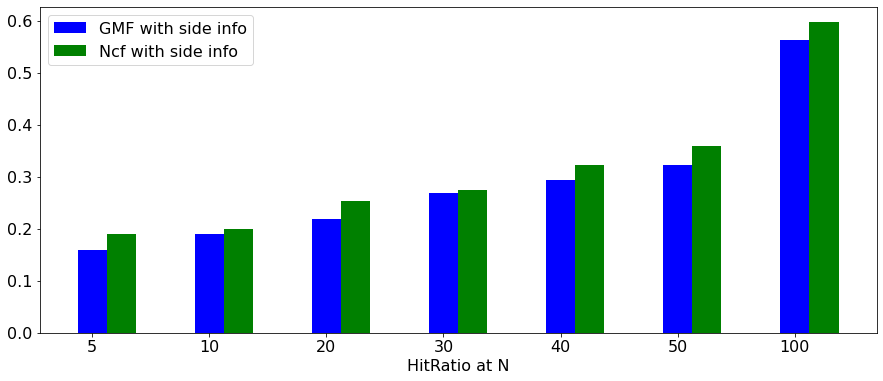

In [924]:
#performce comparison between NCF with and without side info
import matplotlib.pyplot as plt
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.rcParams['font.size'] = '16'

plt.bar(X + 0.00, plot_hit_ratio_als_gmf_model_side1, color = 'b', width = 0.25, label='GMF with side info')
plt.bar(X + 0.25, plot_hit_ratio_als_ncf_model_side1, color = 'g', width = 0.25, label='Ncf with side info')
# plt.bar(X + 0.50, plot_recall_full_model, color = 'r', width = 0.25, label='Full_Model')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

# NueMF with side info

In [926]:
full_concat_side = tf.keras.layers.Concatenate()([ncf_hidden_side, gmf_hidden_side])
full_hidden_side  = Dense(1, activation="sigmoid")(full_concat_side )
full_model_side  = Model(inputs=[
    
    ncf_user_input_cust_code_side,ncf_user_input_cust_type_side,
    ncf_item_input_prod_code_side, ncf_item_input_prod_type_side,
    user_input_cust_code_side,user_input_cust_type_side,
    item_input_prod_code_side, item_input_prod_type_side

    ], outputs=full_hidden_side )

for layer in full_model_side.layers[0:-1]:
    layer.trainable=False
    
from keras.optimizers import Adam,SGD
opt=SGD(learning_rate=0.001,momentum=0.5)
full_model_side.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','mae'])
early_stopping_cb = EarlyStopping(patience=3,restore_best_weights=True,monitor='loss')
full_model_side.fit(
    [
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['customer_type_id']),
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['product_type_id']),
 
        
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['customer_type_id']),
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['product_type_id']),
        
    ],y_train,epochs=3,batch_size=1000, verbose=1,callbacks=[early_stopping_cb])

Epoch 1/3
4782/4782 [==============================] - 6s 1ms/step - loss: 0.5276 - accuracy: 0.8231 - mae: 0.3811
Epoch 2/3
4782/4782 [==============================] - 5s 1ms/step - loss: 0.3583 - accuracy: 0.8619 - mae: 0.2249
Epoch 3/3
4782/4782 [==============================] - 5s 1ms/step - loss: 0.3511 - accuracy: 0.8634 - mae: 0.2096


In [948]:
plot_hit_ratio_NueMF_model_side1 = evaluate_tower_side_info_full(full_model_side)

  0%|          | 4/3589 [00:00<03:47, 15.77it/s]

{119: 0.6794651, 795: 0.63609576, 149: 0.61297613, 616: 0.6055839, 1106: 0.597887, 114: 0.5735465, 1091: 0.5617306, 225: 0.5610525, 1122: 0.5475397, 1059: 0.54465586, 624: 0.51781344, 667: 0.49740192, 206: 0.49581978, 722: 0.47801965, 195: 0.44796544, 343: 0.43341443, 950: 0.43253973, 641: 0.4253234, 443: 0.4188792, 817: 0.41228655, 1131: 0.368008, 1088: 0.36222497, 151: 0.34165797, 1078: 0.32910478, 750: 0.3033808, 831: 0.29983455, 362: 0.2887151, 102: 0.28391248, 402: 0.28339937, 875: 0.27131593, 170: 0.26792803, 237: 0.2595105, 1069: 0.259445, 465: 0.25711992, 687: 0.25437257, 941: 0.24844335, 381: 0.24701539, 188: 0.24513821, 1035: 0.24108681, 745: 0.23917899, 446: 0.2384462, 785: 0.2364184, 354: 0.23612599, 176: 0.2337355, 1004: 0.23280397, 230: 0.23238656, 1048: 0.22790305, 738: 0.22746617, 168: 0.22706403, 811: 0.22133054, 1042: 0.2208342, 768: 0.21929699, 139: 0.21362658, 392: 0.21195763, 341: 0.20978585, 426: 0.20836173, 123: 0.20119993, 277: 0.20096733, 1112: 0.20068583, 614:

  6%|▌         | 200/3589 [00:10<03:03, 18.42it/s]


In [949]:
plot_hit_ratio_NueMF_model_side1

[0.17412935323383086,
 0.19900497512437812,
 0.24378109452736318,
 0.263681592039801,
 0.2885572139303483,
 0.3383084577114428,
 0.5870646766169154]

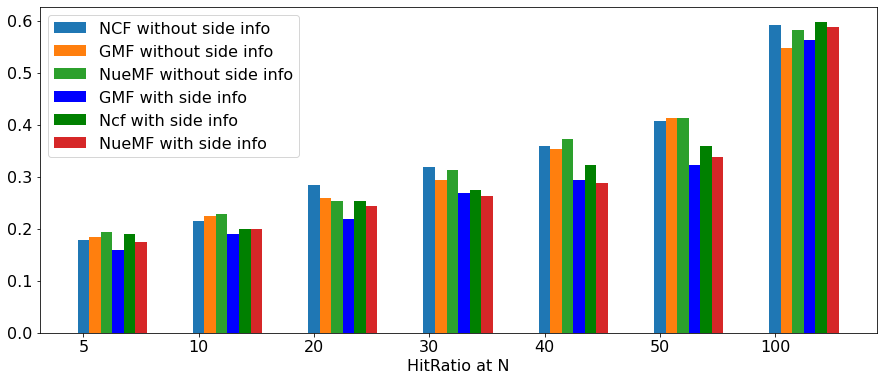

In [1010]:
#performce comparison between two-towers with and without side info
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.bar(X + 0.00, plot_hit_ratio_ncf, width = 0.10, label='NCF without side info')
plt.bar(X + 0.10, plot_hit_ratio_gmf, width = 0.10, label='GMF without side info')
plt.bar(X + 0.20, plot_hit_ratio_full_model, width = 0.10, label='NueMF without side info')

plt.bar(X + 0.30, plot_hit_ratio_als_gmf_model_side1, color = 'b', width = 0.10, label='GMF with side info')
plt.bar(X + 0.40, plot_hit_ratio_als_ncf_model_side1, color = 'g', width = 0.10, label='Ncf with side info')

plt.bar(X + 0.50, plot_hit_ratio_NueMF_model_side1, width = 0.10, label='NueMF with side info')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

In [491]:
customer_set = set(df6['customer_id'])
customer_type_dict=dict()
for customer in tqdm(customer_set):
    temp = count_df[count_df['customer_id']==customer].head(1)
    customer_type_dict[customer] = temp['customer_type_id']

100%|██████████| 227590/227590 [03:13<00:00, 1173.91it/s]


In [490]:
product_type_dict=dict()
for product in tqdm(set(test_set['product_id'])):
    temp = count_df[count_df['product_id']==product].head(1)
    product_type_dict[product] = temp['product_type_id']

100%|██████████| 3589/3589 [00:03<00:00, 1035.85it/s]


In [492]:
#function is used evalue GMF and NCF with sde info.
#it cannot eveluate NueMF with side info
def evaluate_tower_side_info(model):
    total_customer_set = set(data1['customer_id'])

    top_n=1000
    recall_list=[5,10,20,30,40,50,100]

    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]


    def select_top_N(pred,n=50):
        rev=np.argsort(pred.flatten())[::-1]
        res=rev[:n]
        return res

    def predict(product,product_type_id,all_cust_one_hot,all_cust_type_one_hot,test_sub_set):
        
        #print(product)

        #one_hot_prod_code = [one_hot(str(product),total_product)]*len(test_sub_set)    
        
        one_hot_prod_code = [product]*len(test_sub_set)  
        
        one_hot_prod_type_code = [product_type_id]*len(test_sub_set) 
        
#         print("all_cust_one_hot = ",all_cust_one_hot)
#         print("one_hot_prod_code = ",one_hot_prod_code)
        
        predictions = model.predict([tf.convert_to_tensor(all_cust_one_hot),tf.convert_to_tensor(all_cust_type_one_hot),tf.convert_to_tensor(one_hot_prod_code),tf.convert_to_tensor(one_hot_prod_type_code)])
        res_index = select_top_N(predictions,top_n)
        return res_index,predictions


    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_id']==product]['customer_id'])
#         print("for prodcut_id = ",product)
#         print("db_cust = ",db_customers)
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
#         print("common_customers with in ",n,"are : ",common_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]


    i=0
    result=pd.DataFrame(columns=['Product','Recall','Retrieved Customers','Customers In DB'])
    result=list()
    for product in tqdm(set(test_set['product_id'])):

        right_customer_set = set(data1[data1['product_id']==product]['customer_id'])

        test_sub_set = list(test_set[test_set['product_id']==product]['customer_id'])[0]

        wrtong_set = list(total_customer_set - right_customer_set)  [:top_n-1]

        wrtong_set.append(test_sub_set)

        test_sub_set=wrtong_set  #contains all customer ids need to be tested

        #all_cust_one_hot = [one_hot(str(cust),total_customer) for cust in test_sub_set]
        
        all_cust_one_hot = test_sub_set
        
        all_cust_type_one_hot = [customer_type_dict[cust_id] for cust_id in all_cust_one_hot]
        
        product_type_id = product_type_dict[product]
            

        res_index,predictions = predict(product,product_type_id,all_cust_one_hot,all_cust_type_one_hot,test_sub_set)
        res = dict(zip(np.array(test_sub_set)[res_index],predictions[res_index].flatten()))

        if(i==1):
            print(res)

        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1


    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].mean(),evaluation_recall_at_10[1].mean(),evaluation_recall_at_20[1].mean(),evaluation_recall_at_30[1].mean(),evaluation_recall_at_40[1].mean(),evaluation_recall_at_50[1].mean(),evaluation_recall_at_100[1].mean()]

In [927]:
#function is used to eveluate NueMF only with side info
def evaluate_tower_side_info_full(model):
    total_customer_set = set(data1['customer_id'])

    top_n=1000
    recall_list=[5,10,20,30,40,50,100]

    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]


    def select_top_N(pred,n=50):
        rev=np.argsort(pred.flatten())[::-1]
        res=rev[:n]
        return res

    def predict(product,product_type_id,all_cust_one_hot,all_cust_type_one_hot,test_sub_set):
        
        #print(product)

        #one_hot_prod_code = [one_hot(str(product),total_product)]*len(test_sub_set)    
        
        one_hot_prod_code = [product]*len(test_sub_set)  
        
        one_hot_prod_type_code = [product_type_id]*len(test_sub_set) 
        
#         print("all_cust_one_hot = ",all_cust_one_hot)
#         print("one_hot_prod_code = ",one_hot_prod_code)
        
        predictions = model.predict([
            tf.convert_to_tensor(all_cust_one_hot),
            tf.convert_to_tensor(all_cust_type_one_hot),
            tf.convert_to_tensor(one_hot_prod_code),
            tf.convert_to_tensor(one_hot_prod_type_code),
            
            tf.convert_to_tensor(all_cust_one_hot),
            tf.convert_to_tensor(all_cust_type_one_hot),
            tf.convert_to_tensor(one_hot_prod_code),
            tf.convert_to_tensor(one_hot_prod_type_code)
        
        ])
        res_index = select_top_N(predictions,top_n)
        return res_index,predictions


    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_id']==product]['customer_id'])
#         print("for prodcut_id = ",product)
#         print("db_cust = ",db_customers)
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
#         print("common_customers with in ",n,"are : ",common_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]


    i=0
    result=pd.DataFrame(columns=['Product','Recall','Retrieved Customers','Customers In DB'])
    result=list()
    for product in tqdm(set(test_set['product_id'])):

        right_customer_set = set(data1[data1['product_id']==product]['customer_id'])

        test_sub_set = list(test_set[test_set['product_id']==product]['customer_id'])[0]

        wrtong_set = list(total_customer_set - right_customer_set)  [:top_n-1]

        wrtong_set.append(test_sub_set)

        test_sub_set=wrtong_set  #contains all customer ids need to be tested

        #all_cust_one_hot = [one_hot(str(cust),total_customer) for cust in test_sub_set]
        
        all_cust_one_hot = test_sub_set
        
        all_cust_type_one_hot = [customer_type_dict[cust_id] for cust_id in all_cust_one_hot]
        
        product_type_id = product_type_dict[product]
            

        res_index,predictions = predict(product,product_type_id,all_cust_one_hot,all_cust_type_one_hot,test_sub_set)
        res = dict(zip(np.array(test_sub_set)[res_index],predictions[res_index].flatten()))

        if(i==1):
            print(res)

        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1


    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].mean(),evaluation_recall_at_10[1].mean(),evaluation_recall_at_20[1].mean(),evaluation_recall_at_30[1].mean(),evaluation_recall_at_40[1].mean(),evaluation_recall_at_50[1].mean(),evaluation_recall_at_100[1].mean()]

# After Feature Engineering

# Recency Product

In [910]:
import datetime as dt
Latest_date = dt.datetime.now()
Latest_date

datetime.datetime(2021, 9, 15, 18, 17, 9, 578146)

In [911]:
recency = df6.groupby(['product_code']).apply(lambda x: 
                (Latest_date - dt.datetime.strptime(max(x['transaction_date']), '%Y-%m-%d %H:%M:%S')).days)


recency_gup= list(recency.index)
prod_recency_df=pd.DataFrame(recency_gup,columns=['product_code'])
prod_recency_df['prod_recency']=recency.values
prod_recency_df.head()

,product_code,prod_recency
0,1030,754
1,1037,1748
2,1064,1788
3,1147,1859
4,1177,1861


# Recency Customer

In [539]:
recency = df6.groupby(['customer_code']).apply(lambda x: 
                                                             (Latest_date - dt.datetime.strptime(max(x['transaction_date']), '%Y-%m-%d %H:%M:%S')).days)


recency_gup= list(recency.index)
customer_recency_df=pd.DataFrame(recency_gup,columns=['customer_code'])
customer_recency_df['cust_recency']=recency.values
customer_recency_df.head()

,customer_code,cust_recency
0,235,1915
1,301,1819
2,363,1684
3,391,1801
4,429,1992


# Frequency Product

In [540]:
group_count=df6[['customer_code','product_code']].groupby(['product_code']).size()

gup = list(group_count.index)
frequency_prod = pd.DataFrame(gup,columns=['product_code'])
frequency_prod['prod_frequency'] = list(group_count.values)
frequency_prod.head()

,product_code,prod_frequency
0,1030,1
1,1037,1
2,1064,1
3,1147,1
4,1177,1


# Frequency Customer

In [541]:
group_count=df6[['customer_code','product_code']].groupby(['customer_code']).size()

gup = list(group_count.index)
frequency_cust = pd.DataFrame(gup,columns=['customer_code'])
frequency_cust['cust_frequency'] = list(group_count.values)
frequency_cust.head()

,customer_code,cust_frequency
0,235,6
1,301,1
2,363,1
3,391,1
4,429,2


# Monetory Product

In [542]:
groups=df6[['product_code','cost_of_sales_ex_vat']].groupby(['product_code']).sum('cost_of_sales_ex_vat')
gup = list(groups.index)
prod_monetory_df = pd.DataFrame(gup,columns = ['product_code'])
prod_monetory_df['prod_monetory'] = groups.values
prod_monetory_df.head()

,product_code,prod_monetory
0,1030,4.90
1,1037,6.46
2,1064,12.35
3,1147,9.97
4,1177,7.39


# Monetory Customer

In [544]:
groups = df6[['customer_code','cost_of_sales_ex_vat']].groupby(['customer_code']).sum('cost_of_sales_ex_vat')

gup = list(groups.index)
cust_monetory_df = pd.DataFrame(gup,columns = ['customer_code'])
cust_monetory_df['cust_monetory'] = groups.values
cust_monetory_df.head()

,customer_code,cust_monetory
0,235,36.89
1,301,28.01
2,363,5.69
3,391,5.37
4,429,46.58


# Average spend of customer

In [545]:
groups = df6[['customer_code','avg_cost']].groupby(['customer_code']).sum('avg_cost')

gup = list(groups.index)
avg_monetory_df = pd.DataFrame(gup,columns = ['customer_code'])
avg_monetory_df['avg_cost'] = groups.values
avg_monetory_df.head()

,customer_code,avg_cost
0,235,28.17
1,301,4.67
2,363,5.69
3,391,5.37
4,429,7.47


In [546]:
prod_data = pd.merge(prod_recency_df, frequency_prod ,  how='inner', on=["product_code"])
prod_data = pd.merge(prod_data, prod_monetory_df ,  how='inner', on=["product_code"])
prod_data.head()

,product_code,prod_recency,prod_frequency,prod_monetory
0,1030,754,1,4.90
1,1037,1748,1,6.46
2,1064,1788,1,12.35
3,1147,1859,1,9.97
4,1177,1861,1,7.39


In [547]:
#data = pd.merge(data,  ,  how='inner', on=["customer_code"])
cust_data = pd.merge(customer_recency_df, frequency_cust ,  how='inner', on=["customer_code"])
cust_data = pd.merge(cust_data, cust_monetory_df ,  how='inner', on=["customer_code"])

cust_data = pd.merge(cust_data, avg_monetory_df ,  how='inner', on=["customer_code"])

cust_data.head()

,customer_code,cust_recency,cust_frequency,cust_monetory,avg_cost
0,235,1915,6,36.89,28.17
1,301,1819,1,28.01,4.67
2,363,1684,1,5.69,5.69
3,391,1801,1,5.37,5.37
4,429,1992,2,46.58,7.47


In [548]:
cust_data['avg_cost'] = cust_data['avg_cost'] / cust_data['cust_frequency']
cust_data.head()

,customer_code,cust_recency,cust_frequency,cust_monetory,avg_cost
0,235,1915,6,36.89,4.695
1,301,1819,1,28.01,4.670
2,363,1684,1,5.69,5.690
3,391,1801,1,5.37,5.370
4,429,1992,2,46.58,3.735


In [550]:
final_data.shape

(4781976, 11)

In [551]:
test_set.shape

(3589, 10)

In [654]:
data_final.isnull().any()

customer_code          False
product_code           False
count                  False
customer_id            False
product_id             False
feedback               False
customer_type          False
product_type           False
single_bottle_price     True
customer_type_id       False
product_type_id        False
cust_recency           False
cust_frequency         False
cust_monetory          False
avg_cost               False
prod_recency           False
prod_frequency         False
prod_monetory          False
dtype: bool

In [656]:
data_final['single_bottle_price'][data_final['single_bottle_price'].isnull()]= 0

<ipython-input-656-19edb5ae6f3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['single_bottle_price'][data_final['single_bottle_price'].isnull()]= 0


In [552]:
data_final = pd.merge(final_data, cust_data ,  how='inner', on=["customer_code"])
data_final = pd.merge(data_final, prod_data ,  how='inner', on=["product_code"])
data_final.shape

(4781976, 18)

In [553]:
data_test = pd.merge(test_set, cust_data ,  how='inner', on=["customer_code"])
data_test = pd.merge(data_test, prod_data ,  how='inner', on=["product_code"])
data_test.shape

(3589, 17)

In [572]:
data_count_df = pd.merge(count_df, cust_data ,  how='inner', on=["customer_code"])
data_count_df = pd.merge(data_count_df, prod_data ,  how='inner', on=["product_code"])
data_count_df.shape

(800585, 17)

In [554]:
data_final.head()

,customer_code,product_code,count,customer_id,product_id,feedback,customer_type,product_type,single_bottle_price,customer_type_id,product_type_id,cust_recency,cust_frequency,cust_monetory,avg_cost,prod_recency,prod_frequency,prod_monetory
0,224221950,37323,0.0,174142,4677,0,Retail,Wines,9.49,1,6,1944,3,16.33,5.443333,252,10210,213567.7424
1,18108478,37323,1.0,16299,4677,1,Retail,Wines,9.49,1,6,1780,2,115.16,3.640000,252,10210,213567.7424
2,183220125,37323,0.0,147483,4677,0,Retail,Wines,9.49,1,6,1916,1,20.54,20.540000,252,10210,213567.7424
3,161220090,37323,0.0,128822,4677,0,Retail,Wines,9.49,1,6,1959,1,19.91,3.320000,252,10210,213567.7424
4,161224338,37323,0.0,129041,4677,0,Retail,Wines,9.49,1,6,1892,3,19.01,3.780000,252,10210,213567.7424


In [657]:
X_train = data_final[['customer_id','product_id','customer_type_id','product_type_id']]
X_train1 = data_final[['cust_frequency','cust_monetory','cust_recency','avg_cost','prod_frequency','prod_monetory','single_bottle_price','prod_recency']]
y_train = data_final['feedback']

In [664]:
from sklearn.preprocessing import MinMaxScaler

user_scaler = MinMaxScaler()
item_scaler = MinMaxScaler()

user_data = X_train1[['cust_recency','cust_frequency','cust_monetory','avg_cost']]
item_data = X_train1[['prod_recency','prod_frequency','prod_monetory','single_bottle_price']]

user_scaler.fit(user_data)
item_scaler.fit(item_data)

# transform the test test
user_scaled = user_scaler.transform(user_data)
item_scaled = user_scaler.transform(item_data)

In [659]:
#data['avg_cost'] = data['monetory'] / data['frequency']

Model: "model_105"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input1 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input2 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input1 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input2 (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________

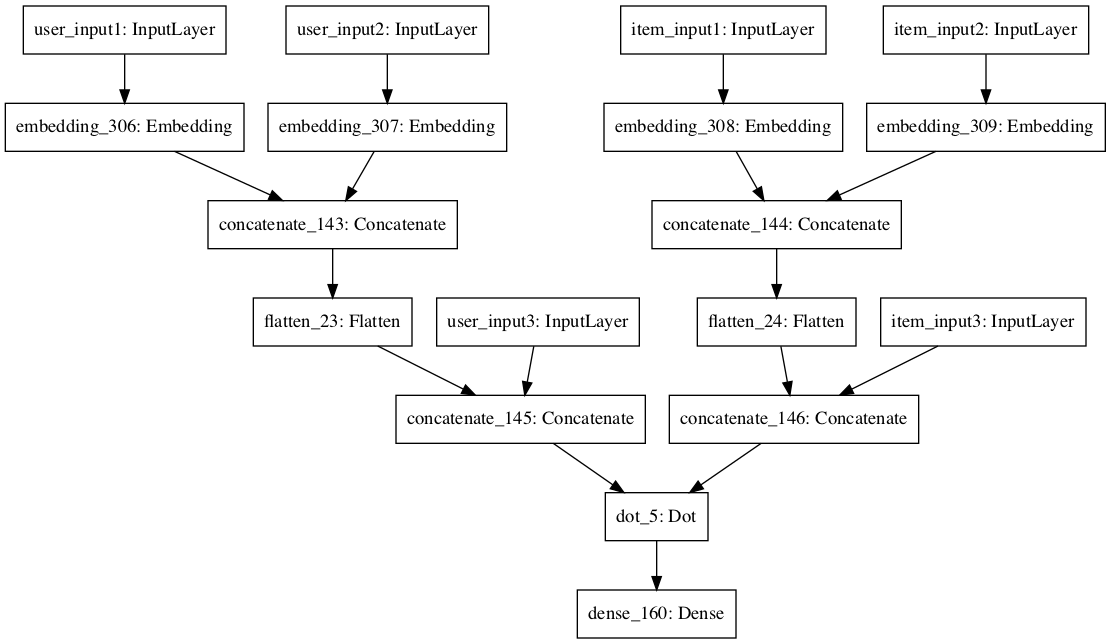

In [934]:
from keras.layers import Embedding,Dense,Dropout,Concatenate,Input,Embedding,merge,Multiply,Flatten,Dot

user_input_cust_code_side_rmf = tf.keras.layers.Input((1 ), name="user_input1")
user_input_cust_type_side_rmf= tf.keras.layers.Input((1 ), name="user_input2")
user_input_side_rmf = tf.keras.layers.Input((4 ), name="user_input3")

item_input_prod_code_side_rmf = tf.keras.layers.Input((1 ), name="item_input1")
item_input_prod_type_side_rmf = tf.keras.layers.Input((1 ), name="item_input2")
item_input_side_rmf = tf.keras.layers.Input((4 ), name="item_input3")

embedding_length=32

gmf_embedding_side1_rmf = tf.keras.layers.Embedding(total_customer, embedding_length)(user_input_cust_code_side_rmf)
gmf_embedding_side12_rmf = tf.keras.layers.Embedding(total_customer_type, 2)(user_input_cust_type_side_rmf)

gmf_embedding_side13_rmf = tf.keras.layers.Embedding(total_product, embedding_length)(item_input_prod_code_side_rmf)
gmf_embedding_side14_rmf = tf.keras.layers.Embedding(total_product_type, 2)(item_input_prod_type_side_rmf)



gmf_concat_side1_rmf = tf.keras.layers.Concatenate()([gmf_embedding_side1_rmf,gmf_embedding_side12_rmf])#,user_input_side])
gmf_concat_side2_rmf = tf.keras.layers.Concatenate()([ gmf_embedding_side13_rmf,gmf_embedding_side14_rmf])#,item_input_side])


gmf_flatten1_rmf = Flatten()(gmf_concat_side1_rmf)

gmf_flatten2_rmf = Flatten()(gmf_concat_side2_rmf)

gmf_last1_rmf = tf.keras.layers.Concatenate()([gmf_flatten1_rmf,user_input_side_rmf])
gmf_last2_rmf = tf.keras.layers.Concatenate()([gmf_flatten2_rmf,item_input_side_rmf])

gmf_merged_side_rmf = Dot(axes=1)([gmf_last1_rmf, gmf_last2_rmf])

#gmf_last = tf.keras.layers.Concatenate()([gmf_flatten,user_input_side,item_input_side])

gmf_hidden_side_rmf = Dense(1, activation="sigmoid")(gmf_merged_side_rmf)

gmf_side_rmf = Model(inputs=[
                             user_input_cust_code_side_rmf,
                             user_input_cust_type_side_rmf,
                             user_input_side_rmf,
                             item_input_prod_code_side_rmf, 
                             item_input_prod_type_side_rmf,
                             item_input_side_rmf
                            ], outputs=gmf_hidden_side_rmf)

gmf_side_rmf.summary()
plot_model(gmf_side_rmf)

In [935]:
gmf_side_rmf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True,monitor='loss')

gmf_side_rmf.fit(
[
    tf.convert_to_tensor(X_train['customer_id']),
    tf.convert_to_tensor(X_train['customer_type_id']),
    tf.convert_to_tensor(user_scaled),
    
    tf.convert_to_tensor(X_train['product_id']),
    tf.convert_to_tensor(X_train['product_type_id']),
    tf.convert_to_tensor(item_scaled)

],
y_train,epochs=2,batch_size=1000,verbose=1,callbacks=[early_stopping_cb])

Epoch 1/2
4782/4782 [==============================] - 93s 19ms/step - loss: 0.4800 - accuracy: 0.8354
Epoch 2/2
4782/4782 [==============================] - 93s 19ms/step - loss: 0.3541 - accuracy: 0.8616


In [940]:
plot_hit_ratio_als_gmf_model_more_side_rfm= evaluate_tower_side_info_segment(gmf_side_rmf)

  0%|          | 4/3589 [00:00<03:55, 15.21it/s]

{795: 0.8535874, 149: 0.72502834, 616: 0.7201507, 1059: 0.662958, 641: 0.65516436, 119: 0.65489674, 170: 0.60145694, 670: 0.59820765, 1106: 0.595126, 667: 0.5949315, 1091: 0.59321135, 817: 0.58173096, 1122: 0.5780287, 225: 0.5520468, 114: 0.5389124, 1069: 0.53567886, 151: 0.4915105, 168: 0.48514393, 237: 0.48419905, 831: 0.45943385, 338: 0.45690453, 369: 0.42910588, 785: 0.42389575, 745: 0.4006106, 123: 0.39743817, 1088: 0.3956498, 941: 0.39322567, 343: 0.38568643, 299: 0.37962303, 176: 0.37636715, 402: 0.3753608, 973: 0.37228706, 741: 0.3711728, 1170: 0.3674336, 984: 0.36089206, 750: 0.35755727, 362: 0.35238177, 1080: 0.3464779, 195: 0.3448533, 478: 0.34370103, 972: 0.3341341, 624: 0.32238635, 370: 0.31930497, 233: 0.31179568, 961: 0.3114685, 354: 0.31129387, 102: 0.30946562, 713: 0.30788112, 111: 0.30546266, 341: 0.29387578, 994: 0.2921969, 374: 0.29205015, 751: 0.28627065, 1035: 0.2860766, 1019: 0.28485954, 392: 0.28071818, 1116: 0.27926975, 514: 0.27498534, 966: 0.27339977, 446: 0.

  6%|▌         | 200/3589 [00:12<03:33, 15.90it/s]


In [941]:
plot_hit_ratio_als_gmf_model_more_side_rfm

[0.1791044776119403,
 0.22388059701492538,
 0.263681592039801,
 0.2935323383084577,
 0.3333333333333333,
 0.3482587064676617,
 0.5223880597014925]

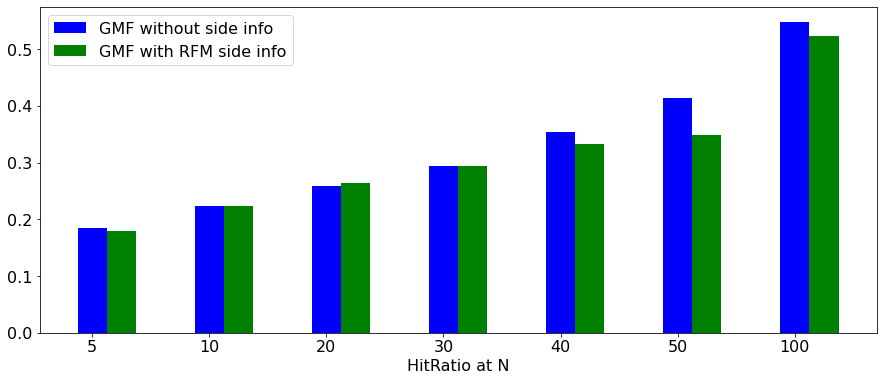

In [1013]:
#performence comparision between GMF with and withour RFM features
import matplotlib.pyplot as plt
X = np.arange(7)
plt.figure(figsize=(15,6))
plt.rcParams['font.size'] = '16'

plt.bar(X + 0.00, plot_hit_ratio_gmf, color = 'b', width = 0.25, label='GMF without side info')
plt.bar(X + 0.25, plot_hit_ratio_als_gmf_model_more_side_rfm, color = 'g', width = 0.25, label='GMF with RFM side info')
# plt.bar(X + 0.50, plot_recall_full_model, color = 'r', width = 0.25, label='Full_Model')
plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at N")
plt.legend()

In [617]:
customer_type_dict=dict()
customer_recency_dict=dict()
customer_frequency_dict=dict()
customer_monetory_dict=dict()
customer_avg_cost_dict=dict()

customer_set = set(data_count_df['customer_id'])

for customer in tqdm(customer_set):
    temp = data_count_df[data_count_df['customer_id']==customer].head(1)
    
    customer_type_dict[customer] = temp['customer_type_id']
    customer_recency_dict[customer] = temp['cust_recency']
    customer_frequency_dict[customer] = temp['cust_frequency']
    customer_monetory_dict[customer] = temp['cust_monetory']
    customer_avg_cost_dict[customer] = temp['avg_cost']

100%|██████████| 227590/227590 [03:18<00:00, 1145.92it/s]


In [618]:
product_type_dict=dict()
product_recency_dict=dict()
product_frequency_dict=dict()
product_monetory_dict=dict()
product_bottle_price_dict=dict()

product_type=[]
for product in tqdm(set(test_set['product_id'])):
    temp = data_count_df[data_count_df['product_id']==product].head(1)
    
    product_type_dict[product] = temp['product_type_id']
    product_recency_dict[product] = temp['prod_recency']
    product_frequency_dict[product] = temp['prod_frequency']
    product_monetory_dict[product] = temp['prod_monetory']
    product_bottle_price_dict[product] = temp['single_bottle_price']

100%|██████████| 3589/3589 [00:03<00:00, 1048.24it/s]


In [646]:
#function is used to eveluate GMF with RFM features
def evaluate_tower_side_info_segment(model):
    total_customer_set = set(data1['customer_id'])
    top_n=1000
    recall_list=[5,10,20,30,40,50,100]

    recall_at_5=[]
    recall_at_10=[]
    recall_at_20=[]
    recall_at_30=[]
    recall_at_40=[]
    recall_at_50=[]
    recall_at_100=[]


    def select_top_N(pred,n=50):
        rev=np.argsort(pred.flatten())[::-1]
        res=rev[:n]
        return res

    def predict(product,product_type_id,x_item,all_cust_one_hot,all_cust_type_one_hot,x_user,test_sub_set):     
        one_hot_prod_code = [product]*len(test_sub_set)       
        one_hot_prod_type_code = [product_type_id]*len(test_sub_set) 
        
        all_x_item = np.array([x_item]*len(test_sub_set)) 
        
        #print(all_x_item.shape)


        
        predictions = model.predict([
            tf.convert_to_tensor(all_cust_one_hot),
            tf.convert_to_tensor(all_cust_type_one_hot),
            tf.convert_to_tensor(x_user),
            
            tf.convert_to_tensor(one_hot_prod_code),
            tf.convert_to_tensor(one_hot_prod_type_code),
            tf.convert_to_tensor(all_x_item)
        
        ])
        res_index = select_top_N(predictions,top_n)
        return res_index,predictions


    def hit_ratio_at_n(res,product,n):
        hit=0
        db_customers = set(test_set[test_set['product_id']==product]['customer_id'])
        pred_customers = set(dict(list(res.items())[:n]).keys())
        common_customers = db_customers.intersection(pred_customers)
        if(len(common_customers)!=0):
            hit=1
        return [product,hit,common_customers]


    i=0
    result=pd.DataFrame(columns=['Product','Recall','Retrieved Customers','Customers In DB'])
    result=list()
    for product in tqdm(set(test_set['product_id'])):

        right_customer_set = set(data1[data1['product_id']==product]['customer_id'])

        test_sub_set = list(test_set[test_set['product_id']==product]['customer_id'])[0]

        wrtong_set = list(total_customer_set - right_customer_set)  [:top_n-1]

        wrtong_set.append(test_sub_set)

        test_sub_set=wrtong_set  #contains all customer ids that need to be tested
        
        all_cust_one_hot = test_sub_set
        
        all_cust_type_one_hot = [customer_type_dict[cust_id] for cust_id in all_cust_one_hot]
        
        
        x_user = [(customer_recency_dict[cust],customer_frequency_dict[cust],customer_monetory_dict[cust],customer_avg_cost_dict[cust]) for cust in all_cust_one_hot]
        
        x_user = np.array(x_user)
        
        x_user = x_user.reshape(x_user.shape[0],x_user.shape[1])
        
        
    
        x_user = user_scaler.transform(x_user)
        
        #x_user = np.array(x_user).reshape(len(x_user),1,len(x_user[0]))
        
    
        x_item = [[product_recency_dict[product],product_frequency_dict[product],product_monetory_dict[product],product_bottle_price_dict[product]]]
    
        
        x_item = np.array(x_item)
        
        
        x_item = x_item.reshape(x_item.shape[0],x_item.shape[1])
    
        x_item = item_scaler.transform(x_item)
        
        x_item=x_item.flatten()
        
        product_type_id = product_type_dict[product]

        res_index,predictions = predict(product,product_type_id,x_item,all_cust_one_hot,all_cust_type_one_hot,x_user,test_sub_set)
        res = dict(zip(np.array(test_sub_set)[res_index],predictions[res_index].flatten()))

        if(i==1):
            print(res)

        for recall in recall_list:
            if recall==5:
                recall_at_5.append(hit_ratio_at_n(res,product,recall))
            if recall==10:
                recall_at_10.append(hit_ratio_at_n(res,product,recall))
            if recall==20:
                recall_at_20.append(hit_ratio_at_n(res,product,recall))
            if recall==30:
                recall_at_30.append(hit_ratio_at_n(res,product,recall))
            if recall==40:
                recall_at_40.append(hit_ratio_at_n(res,product,recall))
            if recall==50:
                recall_at_50.append(hit_ratio_at_n(res,product,recall))
            if recall==100:
                recall_at_100.append(hit_ratio_at_n(res,product,recall))

        if i==200:
            break
        i=i+1


    evaluation_recall_at_5 = pd.DataFrame(recall_at_5).sort_values(by=1, ascending=False)
    evaluation_recall_at_10 = pd.DataFrame(recall_at_10).sort_values(by=1, ascending=False)
    evaluation_recall_at_20 = pd.DataFrame(recall_at_20).sort_values(by=1, ascending=False)
    evaluation_recall_at_30 = pd.DataFrame(recall_at_30).sort_values(by=1, ascending=False)
    evaluation_recall_at_40 = pd.DataFrame(recall_at_40).sort_values(by=1, ascending=False)
    evaluation_recall_at_50 = pd.DataFrame(recall_at_50).sort_values(by=1, ascending=False)
    evaluation_recall_at_100 = pd.DataFrame(recall_at_100).sort_values(by=1, ascending=False)

    return [evaluation_recall_at_5[1].mean(),evaluation_recall_at_10[1].mean(),evaluation_recall_at_20[1].mean(),evaluation_recall_at_30[1].mean(),evaluation_recall_at_40[1].mean(),evaluation_recall_at_50[1].mean(),evaluation_recall_at_100[1].mean()]

In [ ]:
#performnce comparision of all models together

No handles with labels found to put in legend.


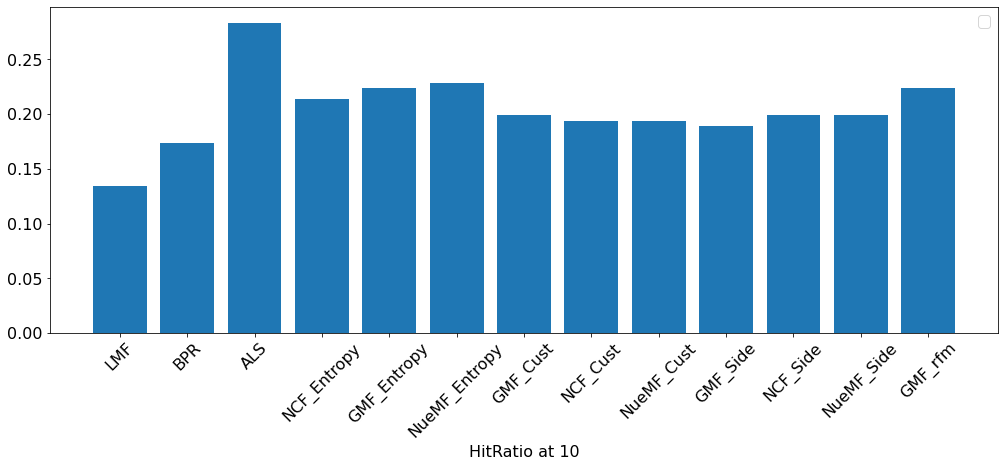

In [963]:
models = [
    'LMF',
    'BPR',
    'ALS',
    'NCF_Entropy',
    'GMF_Entropy',
    'NueMF_Entropy',
    'GMF_Cust',
    'NCF_Cust',
    'NueMF_Cust',
    'GMF_Side',
    'NCF_Side',
    'NueMF_Side',
    'GMF_rfm'
]



perf = [plot_hit_ratio_lmf[1],
plot_hit_ratio_bpr[1],
plot_hit_ratio_als[1],
plot_hit_ratio_ncf[1],
plot_hit_ratio_gmf[1],
plot_hit_ratio_full_model[1],
plot_hit_ratio_als_gmf[1],  
plot_hit_ratio_als_ncf[1],
plot_hit_ratio_als_full_model[1],
plot_hit_ratio_als_gmf_model_side1[1],
plot_hit_ratio_ncf_model_side1[1],
plot_hit_ratio_NueMF_model_side1[1],
plot_hit_ratio_als_gmf_model_more_side_rfm[1]]

import matplotlib.pyplot as plt
X = np.arange(7)
plt.figure(figsize=(17,6))
plt.rcParams['font.size'] = '16'

plt.bar(models , perf)
#plt.xticks([0,1,2,3,4,5,6],[5,10,20,30,40,50,100])
plt.xlabel("HitRatio at 10")
plt.xticks(rotation = 45)
plt.legend()

# Predictions

# GMF_Predictions

In [982]:
def select_top_N(pred,n=50):
    rev=np.argsort(pred.flatten())[::-1]
    res=rev[:n]
    return res

def make_prediction(product,all_customer):
    all_prod = [product]*len(all_customer)
    predictions = gmf.predict([np.array(all_customer),np.array(all_prod)])
    res_index = select_top_N(predictions,top_n)
    return res_index,predictions

def predict(product, all_customer,top_n):
    product_id = product_map_reverse_dict[product]                       # product_id is value and product_code is key 
    res_index,predictions = make_prediction(product_id,all_customer)
    res = dict(zip(np.array(all_customer)[res_index],predictions[res_index].flatten()))
    print("-: Top ",len(res.keys())," recommendations are :-")
    return res

In [983]:
all_customer = list(cutomer_map_dict.keys())   # customer code are values and customer ids are keys    
product= '09018'  
predict(product,all_customer,top_n=10000)

-: Top  10000  recommendations are :-


{126033: 0.93146265,
 81744: 0.9290954,
 22818: 0.9226122,
 8953: 0.9062558,
 19009: 0.90611315,
 192685: 0.8997205,
 136321: 0.8984793,
 178541: 0.88185567,
 126048: 0.87327635,
 56783: 0.871785,
 36353: 0.87148756,
 90173: 0.8666474,
 189458: 0.86213285,
 36413: 0.85477865,
 49469: 0.8545756,
 112135: 0.8542015,
 38164: 0.85219455,
 39925: 0.8499291,
 35370: 0.84934974,
 154889: 0.84452486,
 110211: 0.84422594,
 87367: 0.8414215,
 117035: 0.83479005,
 66071: 0.8297788,
 35052: 0.829742,
 33288: 0.82956505,
 221777: 0.82792777,
 60540: 0.8273476,
 112049: 0.82702833,
 177155: 0.8184053,
 223970: 0.81569445,
 29162: 0.8151374,
 203027: 0.8134239,
 127171: 0.81138927,
 179858: 0.8102995,
 192632: 0.8090631,
 33794: 0.80836946,
 202084: 0.8080315,
 46621: 0.80658567,
 124889: 0.8007052,
 180115: 0.79983455,
 30534: 0.7993152,
 55546: 0.7989874,
 76410: 0.79766595,
 21699: 0.79598945,
 25968: 0.7957631,
 35015: 0.79554695,
 52143: 0.7878643,
 169990: 0.78668386,
 85105: 0.7864672,
 203267

# NueMF(Full_Model Predictions)

In [984]:
def select_top_N(pred,n=50):
    rev=np.argsort(pred.flatten())[::-1]
    res=rev[:n]
    return res

def make_prediction(product,all_customer):
    all_prod = [product]*len(all_customer)
    predictions = full_model.predict([np.array(all_customer),np.array(all_prod),np.array(all_customer),np.array(all_prod)])
    res_index = select_top_N(predictions,top_n)
    return res_index,predictions

def predict(product, all_customer,top_n):
    product_id = product_map_reverse_dict[product]                       # product_id is value and product_code is key 
    res_index,predictions = make_prediction(product_id,all_customer)
    res = dict(zip(np.array(all_customer)[res_index],predictions[res_index].flatten()))
    print("-: Top ",len(res.keys())," recommendations are :-")
    return res

In [985]:
all_customer = list(cutomer_map_dict.keys())   # customer code are values and customer ids are keys    
product= '09018'  
predict(product,all_customer,top_n=10000)

-: Top  10000  recommendations are :-


{126033: 0.9870609,
 22818: 0.9866024,
 81744: 0.9862904,
 136321: 0.9843401,
 19009: 0.9839776,
 8953: 0.98247004,
 192685: 0.9820806,
 178541: 0.98146236,
 36353: 0.9806888,
 112135: 0.97928226,
 56783: 0.97908276,
 35370: 0.9775834,
 90173: 0.9775385,
 126048: 0.9772071,
 39925: 0.97692263,
 36413: 0.9766759,
 189458: 0.9760374,
 38164: 0.97563815,
 221777: 0.97555655,
 117035: 0.9752728,
 87367: 0.9750484,
 49469: 0.97498137,
 33288: 0.9732545,
 60540: 0.9732221,
 154889: 0.9728415,
 110211: 0.97207606,
 112049: 0.97148603,
 35052: 0.970018,
 33794: 0.96989197,
 29162: 0.96826655,
 179858: 0.9670691,
 46621: 0.9669531,
 30534: 0.96665555,
 127171: 0.96663517,
 66071: 0.9662061,
 192632: 0.965987,
 55546: 0.9653626,
 223970: 0.96523875,
 180115: 0.96504474,
 25968: 0.9647361,
 35015: 0.9646747,
 177155: 0.96449304,
 76410: 0.9633284,
 203027: 0.9633273,
 124889: 0.96314657,
 202084: 0.96306777,
 50079: 0.9619338,
 29345: 0.96130246,
 85105: 0.9611832,
 169990: 0.96075904,
 89434: 0.

# Save Models

In [989]:
gmf.save("GMF_Predict_Customers.h5")
gmf.save("NueMF_Predict_Customers.h5")

# Save Variables

In [990]:
import pickle

f = open('customer_id_to_code_dict.pckl', 'wb')
pickle.dump(cutomer_map_dict, f)
f.close()

f = open('customer_code_to_id_dict.pckl', 'wb')
pickle.dump(cutomer_map_reverse_dict, f)
f.close()

f = open('product_id_to_code_dict.pckl', 'wb')
pickle.dump(product_map_dict, f)
f.close()

f = open('product_code_to_id_dict.pckl', 'wb')
pickle.dump(product_map_reverse_dict, f)
f.close()


# Load_Variables

In [ ]:
f = open('customer_id_to_code_dict.pckl', 'rb')
cutomer_map_dict = pickle.load(f)
f.close()

f = open('customer_code_to_id_dict.pckl', 'rb')
cutomer_map_reverse_dict = pickle.load(f)
f.close()

f = open('product_id_to_code_dict.pckl', 'rb')
product_map_dict = pickle.load(f)
f.close()

f = open('product_code_to_id_dict.pckl', 'rb')
product_map_reverse_dict = pickle.load(f)
f.close()

# Load Model

In [ ]:
gmf = keras.models.load_model('GMF_Predict_Customers.h5')
full_model = keras.models.load_model('NueMF_Predict_Customers.h5')